In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pgmpy.estimators import PC
from abbeyFunctions import graph_DAG
from abiFunctions import analyze_wls_pooled_models, wls_pooled_model_analysis
import pingouin
import matplotlib.pyplot as plt

In [2]:
diff_nominal = pd.read_csv('diff_nominal.csv')

diff_nominal.drop(columns=['Unnamed: 0'], inplace=True)

rates_nominal = pd.read_csv('rates_nominal.csv')

rates_nominal.drop(columns=['Unnamed: 0'], inplace=True)

log_nominal = pd.read_csv('log_nominal_data.csv')

In [3]:
nominal_differenced_rates_with_all_variables = diff_nominal.dropna().set_index(['FIPS', 'TimePeriod'])

nominal_rates_with_all_variables = rates_nominal.dropna().set_index(['FIPS', 'TimePeriod'])

nominal_log_with_all_variables = log_nominal.dropna().set_index(['FIPS', 'TimePeriod'])

# Create a dictionary to store the DataFrames
full_DAG_dict = {}

full_DAG_dict['Nominal log (All variables)'] = nominal_log_with_all_variables

full_DAG_dict['Nominal log (without Monetary)'] = nominal_log_with_all_variables.drop(columns=['M4', 'M4I'])

full_DAG_dict['Nominal log (without unem)'] = nominal_log_with_all_variables.drop(columns=['unem'])

full_DAG_dict['Nominal rates (All variables)'] = nominal_rates_with_all_variables

full_DAG_dict['Nominal rates (without Monetary)'] = nominal_rates_with_all_variables.drop(columns=['M4', 'M4I'])

full_DAG_dict['Nominal rates (without unem)'] = nominal_rates_with_all_variables.drop(columns=['unem'])

full_DAG_dict['Nominal diff rates (All variables)'] = nominal_differenced_rates_with_all_variables

full_DAG_dict['Nominal diff rates (without Monetary)'] = nominal_differenced_rates_with_all_variables.drop(columns=['M4', 'M4I'])

full_DAG_dict['Nominal diff rates (without unem)'] = nominal_differenced_rates_with_all_variables.drop(columns=['unem'])

In [4]:
full_df_rates_cluster = pd.read_csv('full_df_rates_cluster.csv')
full_df_rates_cluster.drop(columns=['Unnamed: 0'], inplace=True)

full_df_diff_cluster = pd.read_csv('full_df_diff_cluster.csv')
full_df_diff_cluster.drop(columns=['Unnamed: 0'], inplace=True)

full_df_log_cluster = pd.read_csv('full_df_log_cluster.csv')
full_df_log_cluster.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
full_df_with_cluster = {}

full_df_with_cluster['Rates'] = full_df_rates_cluster.dropna().set_index(['FIPS', 'TimePeriod'])
full_df_with_cluster['Diff rates'] = full_df_diff_cluster.dropna().set_index(['FIPS', 'TimePeriod'])

In [6]:
# Convert boolean columns to integer columns
def convert_bool_to_int(df):
    for col in df.select_dtypes(include='bool').columns:
        df[col] = df[col].astype(int)
    return df

data_cluster_dict = {
    'Nominal rates with clusters': convert_bool_to_int(pd.get_dummies(full_df_rates_cluster, columns=['clusters'], drop_first=True)),
    'Nominal diff rates with clusters': convert_bool_to_int(pd.get_dummies(full_df_diff_cluster, columns=['clusters'], drop_first=True)),
    'Nominal log with clusters': convert_bool_to_int(pd.get_dummies(full_df_log_cluster, columns=['clusters'], drop_first=True))
}


In [7]:
df_rates = data_cluster_dict['Nominal rates with clusters']

df_diff = data_cluster_dict['Nominal diff rates with clusters']

In [8]:
rates_sum = df_rates.dropna()

diff_sum = df_diff.dropna()

In [9]:
summary_rates = rates_sum[['Agri', 'Mini', 'Util', 'M4', 'M4I', 'unem',
       'EFW', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0']].agg(['mean', 'std', 'min', 'max'])

summary_diff = diff_sum[['Agri', 'Mini', 'Util', 'M4', 'M4I', 'unem',
       'EFW', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0']].agg(['mean', 'std', 'min', 'max'])

In [10]:
summary_rates

,Agri,Mini,Util,M4,M4I,unem,EFW,clusters_2.0,clusters_3.0,clusters_4.0
mean,0.016776,-0.007244,0.035747,0.050146,0.007932,6.126820,8.112852,0.370578,0.151095,0.099683
std,0.736230,0.475596,0.403522,0.046424,0.010146,2.639422,0.174835,0.482967,0.358147,0.299581
min,-4.377459,-6.101616,-6.395262,-0.047803,0.000516,1.069231,7.630000,0.000000,0.000000,0.000000
max,4.480537,6.758095,9.326184,0.208378,0.033668,29.392308,8.610000,1.000000,1.000000,1.000000


In [11]:
summary_diff

,Agri,Mini,Util,M4,M4I,unem,EFW,clusters_2.0,clusters_3.0,clusters_4.0
mean,0.007348,-0.016714,-0.008102,0.002423,-0.000377,0.053772,-0.021230,0.372096,0.184109,0.090563
std,1.204870,0.647426,0.553488,0.051955,0.006672,1.415603,0.100993,0.483373,0.387581,0.286993
min,-7.485003,-7.196588,-10.957942,-0.110658,-0.017333,-8.569231,-0.380000,0.000000,0.000000,0.000000
max,8.803364,10.443862,9.861832,0.155660,0.011944,11.384615,0.190000,1.000000,1.000000,1.000000


In [12]:
# summary statistics

# Add a new level to distinguish between rates and differenced rates
summary_rates['Type'] = 'Rates'
summary_diff['Type'] = 'Differenced Rates'

# Set the 'Type' as the first level of the index
summary_rates = summary_rates.set_index('Type', append=True)
summary_diff = summary_diff.set_index('Type', append=True)

# Combine the DataFrames
combined_summary = pd.concat([summary_rates, summary_diff])
combined_summary = combined_summary.reorder_levels(['Type', None], axis=0)
combined_summary = combined_summary.sort_index(level=0)


In [13]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold

def calculate_residuals_k(df, y_var, X_vars, model_type='ols', weights=None, include_constant=False):
    residuals = {}
    for var in [y_var] + X_vars:
        other_vars = [v for v in [y_var] + X_vars if v != var]
        X = df[other_vars].copy()
        if include_constant:
            X = sm.add_constant(X, has_constant='add')
        y = df[var]
        
        if model_type == 'ols':
            model = sm.OLS(y, X)
        elif model_type == 'wls':
            model = sm.WLS(y, X, weights=weights)
        
        results = model.fit()
        residuals[f"$\\epsilon_{{{var}}}$"] = results.resid
    return pd.DataFrame(residuals)

def ols_wls_combinations_kfold(df, dependent_var, independent_vars, model_type='ols', 
                               always_include=None, never_include=None, df_name='df', 
                               include_constant=False, n_splits=10, random_state=None):
    np.random.seed(random_state)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    y = df[dependent_var]

    if model_type not in ['ols', 'wls']:
        raise ValueError("model_type must be either 'ols' or 'wls'")

    if model_type == 'wls':
        # Calculate weights for WLS
        county_unem = df.groupby('FIPS')[dependent_var].var()
        df['weight'] = df['FIPS'].map(lambda x: 1 / county_unem.get(x, np.nan))
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['weight'])

    results = []
    residuals_dict = {}
    best_folds_data = {}

    if always_include is None:
        always_include = []
    if never_include is None:
        never_include = []

    independent_vars = [var for var in independent_vars if var not in never_include]

    for i in range(1, len(independent_vars) + 1):
        for combo in itertools.combinations(independent_vars, i):
            combo = list(always_include) + list(combo)
            X = df[combo].copy()

            if include_constant:
                X = sm.add_constant(X, has_constant='add')
                combo_with_const = ['const'] + combo
            else:
                combo_with_const = combo

            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            mse_list = []
            r_squared_list = []
            beta_estimates = []
            std_errors = []
            p_values = []
            fold_residuals_list = []
            fold_data_list = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
                y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)

                if model_type == 'ols':
                    model = sm.OLS(y_train, X_train).fit()
                elif model_type == 'wls':
                    weights = df['weight'].iloc[train_index].reset_index(drop=True)
                    model = sm.WLS(y_train, X_train, weights=weights).fit()

                y_pred = model.predict(X_test)
                mse = np.mean((y_test - y_pred) ** 2)
                mse_list.append(mse)
                r_squared = model.rsquared
                r_squared_list.append(r_squared)
                beta_estimates.append(model.params)
                std_errors.append(model.bse)
                p_values.append(model.pvalues)

                fold_residuals = {var: [] for var in [dependent_var] + combo_with_const if var != 'const'}
                residuals_y = y_test - y_pred
                fold_residuals[dependent_var].extend(residuals_y)

                # Calculate and store residuals for independent variables
                for var in combo_with_const:
                    if var != 'const':
                        residuals_X = X_test[var] - model.predict(X_test)
                        fold_residuals[var].extend(residuals_X)
                
                fold_residuals_list.append(fold_residuals)
                fold_data_list.append((X_train, X_test, y_train, y_test))

            top_3_indices = np.argsort(mse_list)[:3]
            avg_top_3_mse = np.mean([mse_list[idx] for idx in top_3_indices])
            avg_beta_estimates = np.mean([beta_estimates[idx] for idx in top_3_indices], axis=0)
            avg_std_errors = np.mean([std_errors[idx] for idx in top_3_indices], axis=0)
            avg_p_values = np.mean([p_values[idx] for idx in top_3_indices], axis=0)
            avg_r_squared = np.mean([r_squared_list[idx] for idx in top_3_indices])

            sorted_combo_with_const = sorted(combo_with_const)

            result = {
                'DataFrame': df_name,
                'Model': ', '.join(sorted_combo_with_const),
                'r-squared': avg_r_squared,
                'avg_top_3_mse': avg_top_3_mse,
                'Variables': '<br>'.join(
                    [f'{sorted_combo_with_const[idx]}: {avg_beta_estimates[idx]:.4f} (SE: {avg_std_errors[idx]:.4f}, p: {avg_p_values[idx]:.4f})' for idx in range(len(sorted_combo_with_const))])
            }
            for idx, var in enumerate(sorted_combo_with_const):
                if var == 'const' and not include_constant:
                    result[var] = np.nan
                    result[f'{var}_SE'] = np.nan
                    result[f'{var}_p'] = np.nan
                else:
                    result[var] = avg_beta_estimates[idx]
                    result[f'{var}_SE'] = avg_std_errors[idx]
                    result[f'{var}_p'] = avg_p_values[idx]
            results.append(result)

            # Calculate residuals for the average model based on the top 3 lowest MSEs
            all_residuals = []
            for idx in top_3_indices:
                train_index, test_index = list(kf.split(X))[idx]
                X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
                y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)

                if model_type == 'ols':
                    model = sm.OLS(y_train, X_train).fit()
                elif model_type == 'wls':
                    weights = df['weight'].iloc[train_index].reset_index(drop=True)
                    model = sm.WLS(y_train, X_train, weights=weights).fit()

                y_pred = model.predict(X_test)
                residuals_y = y_test - y_pred
                residuals_df = pd.DataFrame({f"$\\epsilon_{{{dependent_var}}}$": residuals_y})
                
                # Calculate residuals for independent variables
                for var in combo_with_const:
                    if var != 'const':
                        residuals_X = X_test[var] - model.predict(X_test)
                        residuals_df[f"$\\epsilon_{{{var}}}$"] = residuals_X

                all_residuals.append(residuals_df)
            
            # Average residuals across top 3 models
            avg_residuals = pd.concat(all_residuals).groupby(level=0).mean()
            sorted_combo = tuple(sorted(combo_with_const))
            residuals_dict[sorted_combo] = avg_residuals
            
            # Save the best fold data
            best_fold_index = np.argmin(mse_list)
            best_folds_data[sorted_combo] = fold_data_list[best_fold_index]

    results_df = pd.DataFrame(results)
    return results_df, residuals_dict, best_folds_data

# # Usage example
# results_ols_rates_clusters_efw_k, residuals_ols_rates_clusters_efw_k, best_fold_data_ols = ols_wls_combinations_kfold(
#     df_rates, dv, iv, model_type='ols', always_include=None, never_include=None, df_name='Rates ols)', 
#     include_constant=True, n_splits=5, random_state=42)

# Function to get merged data from best_fold_data regardless of order
def get_best_fold_data_merged(best_fold_data, *vars):
    sorted_vars = tuple(sorted(vars))
    if sorted_vars in best_fold_data:
        X_train, X_test, y_train, y_test = best_fold_data[sorted_vars]
        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)
        return train_data, test_data
    else:
        raise KeyError(f"Combination {sorted_vars} not found in best_fold_data.")

# # Access the best fold data without considering order and merge it
# try:
#     train_data, test_data = get_best_fold_data_merged(best_fold_data_ols, 'clusters_2.0', 'Agri', 'const')
#     print("Best fold data accessed and merged successfully.")
# except KeyError as e:
#     print(e)

# # Save to CSV
# train_data.to_csv('best_fold_train_data.csv', index=False)
# test_data.to_csv('best_fold_test_data.csv', index=False)


In [14]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold

def calculate_residuals_k(df, y_var, X_vars, model_type='ols', weights=None, include_constant=False):
    residuals = {}
    for var in [y_var] + X_vars:
        other_vars = [v for v in [y_var] + X_vars if v != var]
        X = df[other_vars].copy()
        if include_constant:
            X = sm.add_constant(X, has_constant='add')
        y = df[var]
        
        if model_type == 'ols':
            model = sm.OLS(y, X)
        elif model_type == 'wls':
            model = sm.WLS(y, X, weights=weights)
        
        results = model.fit()
        residuals[f"$\\epsilon_{{{var}}}$"] = results.resid
    return pd.DataFrame(residuals)

def ols_wls_combinations_kfold(df, dependent_var, independent_vars, model_type='ols', 
                               always_include=None, never_include=None, df_name='df', 
                               include_constant=False, n_splits=10, random_state=None):
    np.random.seed(random_state)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    y = df[dependent_var]

    if model_type not in ['ols', 'wls']:
        raise ValueError("model_type must be either 'ols' or 'wls'")

    if model_type == 'wls':
        # Calculate weights for WLS
        county_unem = df.groupby('FIPS')[dependent_var].var()
        df['weight'] = df['FIPS'].map(lambda x: 1 / county_unem.get(x, np.nan))
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['weight'])

    results = []
    residuals_dict = {}
    best_folds_data = {}

    if always_include is None:
        always_include = []
    if never_include is None:
        never_include = []

    independent_vars = [var for var in independent_vars if var not in never_include]

    for i in range(1, len(independent_vars) + 1):
        for combo in itertools.combinations(independent_vars, i):
            combo = list(always_include) + list(combo)
            X = df[combo].copy()

            if include_constant:
                X = sm.add_constant(X, has_constant='add')
                combo_with_const = ['const'] + combo
            else:
                combo_with_const = combo

            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            mse_list = []
            r_squared_list = []
            beta_estimates = []
            std_errors = []
            p_values = []
            fold_residuals_list = []
            fold_data_list = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
                y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)

                if model_type == 'ols':
                    model = sm.OLS(y_train, X_train).fit()
                elif model_type == 'wls':
                    weights = df['weight'].iloc[train_index].reset_index(drop=True)
                    model = sm.WLS(y_train, X_train, weights=weights).fit()

                y_pred = model.predict(X_test)
                mse = np.mean((y_test - y_pred) ** 2)
                mse_list.append(mse)
                r_squared = model.rsquared
                r_squared_list.append(r_squared)
                beta_estimates.append(model.params)
                std_errors.append(model.bse)
                p_values.append(model.pvalues)

                fold_residuals = {var: [] for var in [dependent_var] + combo_with_const if var != 'const'}
                residuals_y = y_test - y_pred
                fold_residuals[dependent_var].extend(residuals_y)

                # Calculate and store residuals for independent variables
                for var in combo_with_const:
                    if var != 'const':
                        residuals_X = X_test[var] - model.predict(X_test)
                        fold_residuals[var].extend(residuals_X)
                
                fold_residuals_list.append(fold_residuals)
                fold_data_list.append((X_train, X_test, y_train, y_test))

            top_3_indices = np.argsort(mse_list)[:3]
            avg_top_3_mse = np.mean([mse_list[idx] for idx in top_3_indices])
            avg_beta_estimates = np.mean([beta_estimates[idx] for idx in top_3_indices], axis=0)
            avg_std_errors = np.mean([std_errors[idx] for idx in top_3_indices], axis=0)
            avg_p_values = np.mean([p_values[idx] for idx in top_3_indices], axis=0)
            avg_r_squared = np.mean([r_squared_list[idx] for idx in top_3_indices])

            sorted_combo_with_const = sorted(combo_with_const)

            result = {
                'DataFrame': df_name,
                'Model': ', '.join(sorted_combo_with_const),
                'r-squared': avg_r_squared,
                'avg_top_3_mse': avg_top_3_mse,
                'Variables': '<br>'.join(
                    [f'{sorted_combo_with_const[idx]}: {avg_beta_estimates[idx]:.4f} (SE: {avg_std_errors[idx]:.4f}, p: {avg_p_values[idx]:.4f})' for idx in range(len(sorted_combo_with_const))])
            }
            for idx, var in enumerate(sorted_combo_with_const):
                if var == 'const' and not include_constant:
                    result[var] = np.nan
                    result[f'{var}_SE'] = np.nan
                    result[f'{var}_p'] = np.nan
                else:
                    result[var] = avg_beta_estimates[idx]
                    result[f'{var}_SE'] = avg_std_errors[idx]
                    result[f'{var}_p'] = avg_p_values[idx]
            results.append(result)

            # Calculate residuals for the average model based on the top 3 lowest MSEs
            all_residuals = []
            for idx in top_3_indices:
                train_index, test_index = list(kf.split(X))[idx]
                X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
                y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)

                if model_type == 'ols':
                    model = sm.OLS(y_train, X_train).fit()
                elif model_type == 'wls':
                    weights = df['weight'].iloc[train_index].reset_index(drop=True)
                    model = sm.WLS(y_train, X_train, weights=weights).fit()

                y_pred = model.predict(X_test)
                residuals_y = y_test - y_pred
                residuals_df = pd.DataFrame({f"$\\epsilon_{{{dependent_var}}}$": residuals_y})
                
                # Calculate residuals for independent variables
                for var in combo_with_const:
                    if var != 'const':
                        residuals_X = X_test[var] - model.predict(X_test)
                        residuals_df[f"$\\epsilon_{{{var}}}$"] = residuals_X

                all_residuals.append(residuals_df)
            
            # Average residuals across top 3 models
            avg_residuals = pd.concat(all_residuals).groupby(level=0).mean()
            sorted_combo = tuple(sorted(combo_with_const))
            residuals_dict[sorted_combo] = avg_residuals
            
            # Save the best fold data
            best_fold_index = np.argmin(mse_list)
            best_folds_data[sorted_combo] = fold_data_list[best_fold_index]

    results_df = pd.DataFrame(results)
    return results_df, residuals_dict, best_folds_data

# # Usage example
# results_ols_rates_clusters_efw_k, residuals_ols_rates_clusters_efw_k, best_fold_data_ols = ols_wls_combinations_kfold(
#     df_rates, dv, iv, model_type='ols', always_include=None, never_include=None, df_name='Rates ols)', 
#     include_constant=True, n_splits=5, random_state=42)

# Function to get merged data from best_fold_data regardless of order
def get_best_fold_data_merged(best_fold_data, *vars):
    sorted_vars = tuple(sorted(vars))
    if sorted_vars in best_fold_data:
        X_train, X_test, y_train, y_test = best_fold_data[sorted_vars]
        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)
        return train_data, test_data
    else:
        raise KeyError(f"Combination {sorted_vars} not found in best_fold_data.")

# # Access the best fold data without considering order and merge it
# try:
#     train_data, test_data = get_best_fold_data_merged(best_fold_data_ols, 'clusters_2.0', 'Agri', 'const')
#     print("Best fold data accessed and merged successfully.")
# except KeyError as e:
#     print(e)

# # Save to CSV
# train_data.to_csv('best_fold_train_data.csv', index=False)
# test_data.to_csv('best_fold_test_data.csv', index=False)


In [15]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

def filter_results_table(results_dict, df_name, variable_combinations):
    # Extract the relevant dataframe from the results dictionary
    df_results = pd.DataFrame(results_dict[df_name])
    
    # Convert 'Model' column to sets of variables for easier comparison
    df_results['Model'] = df_results['Model'].apply(lambda x: set(x.split(', ')))
    
    # Convert each set of variables in variable_combinations to sets for comparison
    variable_combinations = [set(combo) for combo in variable_combinations]
    
    # Filter the DataFrame for rows where the 'Model' matches any of the variable combinations
    filtered_df = df_results[
        df_results['Model'].apply(lambda x: any(x == combo for combo in variable_combinations))
    ]
    
    return filtered_df

def significance_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

def format_estimate(beta, std_error, p_value):
    stars = significance_stars(p_value)
    if pd.notna(std_error):
        return f"{beta:.4f}{stars}<br>({std_error:.4f})"
    return f"{beta:.4f}{stars}"

def display_results_table(filtered_df, variable_combinations, column_names=None, exclude_rows=None):
    if filtered_df.empty:
        print("No matching results found.")
        return
    
    # Dynamically determine variables and metrics from the filtered DataFrame
    variables_and_metrics = filtered_df.columns.tolist()
    variables_and_metrics.remove('Model')  # Remove 'Model' as it's used for filtering
    variables_and_metrics.remove('DataFrame')  # Remove 'DataFrame' as it's not a variable/metric

    # Initialize the result DataFrame with the index of all potential variables and metrics
    results_table = pd.DataFrame(index=variables_and_metrics)
    
    # Use custom column names if provided, otherwise use the variable combinations
    if column_names:
        assert len(column_names) == len(variable_combinations), "Length of column_names must match variable_combinations"
        model_columns = column_names
    else:
        model_columns = [', '.join(combo) for combo in variable_combinations]
    
    # Add each model's results to the table
    for model_vars, model_name in zip(variable_combinations, model_columns):
        model_data = filtered_df[filtered_df['Model'].apply(lambda x: x == model_vars)]
        
        if not model_data.empty:
            model_data = model_data.iloc[0]
            for var in variables_and_metrics:
                if var in model_data.index and not var.endswith('_SE') and not var.endswith('_p'):
                    # Skip adding data for excluded rows
                    if exclude_rows and var in exclude_rows:
                        continue
                    beta = model_data[var]
                    std_error = model_data.get(f'{var}_SE', np.nan)
                    p_value = model_data.get(f'{var}_p', np.nan)
                    
                    # Store formatted estimate even if std_error or p_value is NaN
                    results_table.loc[var, model_name] = format_estimate(beta, std_error, p_value)
    
    # Drop rows that have names ending with '_SE' or '_p'
    results_table = results_table[~results_table.index.str.endswith(('_SE', '_p'))]
    
    # Drop rows with all NaN values
    results_table.dropna(how='all', inplace=True)
    
    # Apply CSS styling to center align column headers
    results_table_styled = results_table.style.set_table_styles([
        {'selector': 'th.col_heading', 'props': [('text-align', 'center')]}
    ])
    
    # Display the results table with centered column headers
    display(results_table_styled)
    
    # Add the legend for significance stars
    legend_html = """
    <br><br>
    <strong>Significance legend:</strong><br>
    <strong>*</strong> p < 0.1<br>
    <strong>**</strong> p < 0.05<br>
    <strong>***</strong> p < 0.01
    """
    display(HTML(legend_html))

In [62]:
import matplotlib.pyplot as plt
import dataframe_image as dfi

def display_results_table(filtered_df, variable_combinations, column_names=None, exclude_rows=None, save_path=None, title=None):
    if filtered_df.empty:
        print("No matching results found.")
        return
    
    # Dynamically determine variables and metrics from the filtered DataFrame
    variables_and_metrics = filtered_df.columns.tolist()
    variables_and_metrics.remove('Model')  # Remove 'Model' as it's used for filtering
    variables_and_metrics.remove('DataFrame')  # Remove 'DataFrame' as it's not a variable/metric

    # Initialize the result DataFrame with the index of all potential variables and metrics
    results_table = pd.DataFrame(index=variables_and_metrics)
    
    # Use custom column names if provided, otherwise use the variable combinations
    if column_names:
        assert len(column_names) == len(variable_combinations), "Length of column_names must match variable_combinations"
        model_columns = column_names
    else:
        model_columns = [', '.join(combo) for combo in variable_combinations]
    
    # Add each model's results to the table
    for model_vars, model_name in zip(variable_combinations, model_columns):
        model_data = filtered_df[filtered_df['Model'].apply(lambda x: x == model_vars)]
        
        if not model_data.empty:
            model_data = model_data.iloc[0]
            for var in variables_and_metrics:
                if var in model_data.index and not var.endswith('_SE') and not var.endswith('_p'):
                    # Skip adding data for excluded rows
                    if exclude_rows and var in exclude_rows:
                        continue
                    beta = model_data[var]
                    std_error = model_data.get(f'{var}_SE', np.nan)
                    p_value = model_data.get(f'{var}_p', np.nan)
                    
                    # Store formatted estimate even if std_error or p_value is NaN
                    results_table.loc[var, model_name] = format_estimate(beta, std_error, p_value)
    
    # Drop rows that have names ending with '_SE' or '_p'
    results_table = results_table[~results_table.index.str.endswith(('_SE', '_p'))]
    
    # Drop rows with all NaN values
    results_table.dropna(how='all', inplace=True)
    
    # Apply CSS styling to center align column headers
    results_table_styled = results_table.style.set_table_styles([
        {'selector': 'th.col_heading', 'props': [('text-align', 'center')]}
    ])
    
    # Save the styled table as a PNG if a save path is provided
    if save_path:
        # Create a Matplotlib figure to include the title and table
        fig, ax = plt.subplots(figsize=(10, 8))
        if title:
            plt.text(0.5, 0.95, title, fontsize=16, ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')  # Turn off the axes
        dfi.export(results_table_styled, save_path)
        plt.close(fig)
        print(f"Table saved as PNG at: {save_path}")
    
    # Display the table title (if provided)
    if title:
        display(HTML(f"<h2 style='text-align:center'>{title}</h2>"))
    
    # Display the results table with centered column headers
    display(results_table_styled)
    
    # Add the legend for significance stars
    legend_html = """
    <br><br>
    <strong>Significance legend:</strong><br>
    <strong>*</strong> p < 0.1<br>
    <strong>**</strong> p < 0.05<br>
    <strong>***</strong> p < 0.01
    """
    display(HTML(legend_html))


In [16]:
dv = 'unem'
iv = ['Agri', 'Mini', 'Util', 'EFW', 'M4', 'M4I', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0']

In [17]:
# Rates ols
results_ols_rates_clusters_efw_k, residuals_ols_rates_clusters_efw_k, best_rates_data_ols = ols_wls_combinations_kfold(df_rates, dv, iv, 
                                                                           model_type='ols', 
                                                                           always_include=None, 
                                                                           never_include=None, 
                                                                           df_name='Rates ols)', 
                                                                           include_constant=True,
                                                                           n_splits=5, random_state=42)


#rates, wls, clusters, efw
results_wls_rates_clusters_efw_k, residuals_wls_rates_clusters_efw_k, best_rates_data_wls = ols_wls_combinations_kfold(df_rates, dv, iv, 
                                                                           model_type='wls', 
                                                                           always_include=None, 
                                                                           never_include=None, 
                                                                           df_name='Rates wls)', 
                                                                           include_constant=True,
                                                                           n_splits=5, random_state=42)


#diff rates, ols, cluster, efw
results_ols_diff_rates_clusters_efw_k, residuals_ols_diff_rates_clusters_efw_k, best_diff_rates_ols = ols_wls_combinations_kfold(df_diff, dv, iv, 
                                                                                     model_type='ols', 
                                                                                     always_include=None, 
                                                                                     never_include=None, 
                                                                                     df_name='Diff rates ols', 
                                                                                     include_constant=False,
                                                                           n_splits=5, random_state=42)




# Combine the results and residuals into dictionaries
results_dict_combo_k = {
    'Rates wls': results_wls_rates_clusters_efw_k,
    'Rates ols': results_ols_rates_clusters_efw_k,
    'Diff rates ols': results_ols_diff_rates_clusters_efw_k
}

residuals_dict_combo_k = {
    'Rates wls': residuals_wls_rates_clusters_efw_k,
    'Rates ols': residuals_ols_rates_clusters_efw_k,
    'Diff rates ols': residuals_ols_diff_rates_clusters_efw_k
}

In [18]:
rates_try = 'Rates wls'

variable_combok = [
    {'const', 'M4', 'M4I'},
    {'const', 'Agri', 'Util', 'Mini'},
    {'const', 'Agri', 'Mini', 'Util', 'M4', 'M4I'},
    {'const', 'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW'},
    {'const', 'M4', 'M4I', 'Agri', 'Mini', 'Util', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0'},
    {'const', 'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW' ,'clusters_2.0', 'clusters_3.0', 'clusters_4.0'}]

column_names = [
    "M4's only",
    'Sectors only',
    'M4+sectors',
    'M4+sectors+EFW',
    'M4+sectors+clusters',
    'All variables'
]

# Specify the row(s) to exclude from display
exclude_rows = ['Variables']

rates_kfold = filter_results_table(results_dict_combo_k, rates_try, variable_combok)

In [19]:
rates_try_ols_k = 'Rates ols'

# Specify the row(s) to exclude from display
exclude_rows = ['Variables']

rates_k_ols = filter_results_table(results_dict_combo_k, rates_try_ols_k, variable_combok)

In [20]:
diff_rates_try = 'Diff rates ols'

variable_combinationsk = [
    {'M4', 'M4I'},
    {'Agri', 'Util', 'Mini'},
    {'Agri', 'Mini', 'Util', 'M4', 'M4I'},
    {'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW'},
    {'M4', 'M4I', 'Agri', 'Mini', 'Util', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0'},
    {'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW' ,'clusters_2.0', 'clusters_3.0', 'clusters_4.0'}]

column_names = [
    "M4's only",
    'Sectors only',
    'M4+sectors',
    'M4+sectors+EFW',
    'M4+sectors+clusters',
    'All variables'
]

# Specify the row(s) to exclude from display
exclude_rows = ['Variables']

diff_rates_kfold = filter_results_table(results_dict_combo_k, diff_rates_try, variable_combinationsk)

In [65]:
print('Rates ols k-fold :')
print(display_results_table(rates_k_ols, variable_combok, column_names, exclude_rows,
                            save_path = "rates_k_ols1.png",
                           title="Table 1. K-fold OLS (Rates)"))
print('Differenced Rates ols k-fold :')
print(display_results_table(diff_rates_kfold, variable_combinationsk, column_names, exclude_rows,
                            save_path = "diff_rates_k_ols.png",
                           title="Table 2. K-fold OLS (Differenced Rates)"))

Rates ols k-fold :
Table saved as PNG at: rates_k_ols1.png


,M4's only,Sectors only,M4+sectors,M4+sectors+EFW,M4+sectors+clusters,All variables
r-squared,0.1668,0.0037,0.1690,0.2281,0.5634,0.5923
avg_top_3_mse,5.7620,6.8756,5.7459,5.3451,3.0024,2.7978
Variables,nan,nan,nan,nan,nan,nan
Agri,nan,6.1309***(0.0169),7.4852***(0.0247),45.9159***(0.8839),8.3324***(0.0228),35.4134***(0.6471)
const,-51.9645***(1.5284),-0.1092**(0.0416),-51.7691***(1.5286),-1.0405(1.8790),2.7607***(0.0396),2.7400***(0.0382)
Mini,nan,0.0250(0.0228),-0.0972**(0.0381),-4.8021***(0.1104),-0.0130(0.0276),-3.3894***(0.0809)
Util,nan,-0.3208***(0.0353),-18.8198***(0.3327),-16.3339***(0.3257),-18.5247***(0.2418),-16.7773***(0.2374)
EFW,nan,nan,nan,-0.0110(0.0201),nan,0.0226(0.0146)
M4,7.4878***(0.0247),nan,-0.0208(0.0208),-0.2359***(0.0311),0.0170(0.0151),-0.1822***(0.0226)
M4I,-18.8825***(0.3328),nan,-0.2432***(0.0322),-0.0594(0.0367),-0.1846***(0.0234),0.0068(0.0266)


None
Differenced Rates ols k-fold :
Table saved as PNG at: diff_rates_k_ols.png


,M4's only,Sectors only,M4+sectors,M4+sectors+EFW,M4+sectors+clusters,All variables
r-squared,0.2725,0.0051,0.2732,0.4222,0.2748,0.4238
avg_top_3_mse,1.4246,1.9204,1.4236,1.1450,1.4218,1.1414
Variables,nan,nan,nan,nan,nan,nan
Agri,nan,0.0616***(0.0081),0.0146**(0.0069),0.0194***(0.0062),0.0145*(0.0069),0.0199***(0.0062)
Mini,nan,-0.0917***(0.0150),-13.2944***(0.1598),-7.3627***(0.1633),-13.3352***(0.1598),-7.1947***(0.1646)
Util,nan,-0.0631***(0.0176),-41.2901***(1.2417),-25.7796***(1.1266),-40.9370***(1.2415),-25.8112***(1.1251)
EFW,nan,nan,nan,-0.0510***(0.0115),nan,-0.0532***(0.0114)
M4,-13.3472***(0.1592),nan,-0.0447***(0.0129),0.0247*(0.0134),-0.0430***(0.0128),0.0239*(0.0134)
M4I,-41.4516***(1.2413),nan,-0.0227(0.0150),-6.1614***(0.0828),-0.0214(0.0150),-6.2900***(0.0844)
clusters_2.0,nan,nan,nan,nan,0.0828***(0.0136),-0.0592***(0.0123)


None


In [22]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm

def calculate_residuals(df, y_var, X_vars, model_type='ols', weights=None, include_constant=False):
    residuals = {}
    for var in [y_var] + X_vars:
        other_vars = [v for v in [y_var] + X_vars if v != var]
        X = df[other_vars].copy()
        if include_constant:
            X = sm.add_constant(X, has_constant='add')
        y = df[[var]]
        
        if model_type == 'ols':
            model = sm.OLS(y, X)
        elif model_type == 'wls':
            model = sm.WLS(y, X, weights=weights)
        
        results = model.fit()
        residuals[f"$\\epsilon_{{{var}}}$"] = results.resid
    return pd.DataFrame(residuals)

def ols_wls_combinations_full(df, dependent_var, independent_vars, model_type='ols', 
                              always_include=None, never_include=None, df_name='df', 
                              include_constant=False):
    np.random.seed(None)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    if model_type not in ['ols', 'wls']:
        raise ValueError("model_type must be either 'ols' or 'wls'")

    if model_type == 'wls':
        county_unem = df.groupby('FIPS')[dependent_var].var()
        df['weight'] = df['FIPS'].map(lambda x: 1 / county_unem.get(x, np.nan))
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['weight'])
        weights = df['weight']
    else:
        weights = None

    if always_include is None:
        always_include = []
    if never_include is None:
        never_include = []

    independent_vars = [var for var in independent_vars if var not in never_include]

    results = []
    residuals_dict = {}

    for i in range(1, len(independent_vars) + 1):
        for combo in itertools.combinations(independent_vars, i):
            combo = list(always_include) + list(combo)
            X = df[combo].copy()

            if include_constant:
                X = sm.add_constant(X, has_constant='add')

            common_index = df.index.intersection(X.index)
            y_common = df.loc[common_index, dependent_var]
            X_common = X.loc[common_index]

            if model_type == 'ols':
                model = sm.OLS(y_common, X_common).fit()
            elif model_type == 'wls':
                weights_common = weights.loc[common_index]
                model = sm.WLS(y_common, X_common, weights=weights_common).fit()

            beta_estimates = model.params
            std_errors = model.bse
            p_values = model.pvalues
            r_squared = model.rsquared
            y_pred = model.predict(X_common)
            mse = np.mean((y_common - y_pred) ** 2)

            # Format the variables in a readable manner
            formatted_vars = [
                f'{var}: {beta_estimates[idx + int(include_constant)]:.4f} (SE: {std_errors[idx + int(include_constant)]:.4f}, p: {p_values[idx + int(include_constant)]:.4f})'
                for idx, var in enumerate(combo)
            ]

            result = {
                'DataFrame': df_name,
                'Model': ', '.join(['const'] + combo) if include_constant else ', '.join(combo),
                'r-squared': r_squared,
                'MSE': mse,
                'Variables': '<br>'.join(formatted_vars)
            }

            for idx, var in enumerate(combo):
                result[var] = beta_estimates[idx + int(include_constant)]
                result[f'{var}_SE'] = std_errors[idx + int(include_constant)]
                result[f'{var}_p'] = p_values[idx + int(include_constant)]

            if include_constant:
                result['const'] = beta_estimates[0]
                result['const_SE'] = std_errors[0]
                result['const_p'] = p_values[0]
                
            results.append(result)

            # Store residuals for the current combination
            sorted_combo = tuple(sorted(combo))
            residuals_dict[sorted_combo] = calculate_residuals(df.loc[common_index], dependent_var, combo, model_type=model_type, weights=weights_common if model_type == 'wls' else None, include_constant=include_constant)

    results_df = pd.DataFrame(results)
    return results_df, residuals_dict

In [23]:
# Rates ols
results_ols_rates, residuals_ols_rates = ols_wls_combinations_full(df_rates, dv, iv, 
                                                                           model_type='ols', 
                                                                           always_include=None, 
                                                                           never_include=None, 
                                                                           df_name='Rates ols)', 
                                                                           include_constant=True)


#rates, wls, clusters, efw
results_wls_rates, residuals_wls_rates = ols_wls_combinations_full(df_rates, dv, iv, 
                                                                           model_type='wls', 
                                                                           always_include=None, 
                                                                           never_include=None, 
                                                                           df_name='Rates wls)',
                                                                          include_constant=True)


#diff rates, ols, cluster, efw
results_ols_diff_rates, residuals_ols_diff_rates = ols_wls_combinations_full(df_diff, dv, iv, 
                                                                                     model_type='ols', 
                                                                                     always_include=None, 
                                                                                     never_include=None, 
                                                                                     df_name='Diff rates ols', 
                                                                                     include_constant=False)




# Combine the results and residuals into dictionaries
results_dict_full = {
    'Rates wls': results_wls_rates,
    'Rates ols': results_ols_rates,
    'Diff rates ols': results_ols_diff_rates
}

residuals_dict_full = {
    'Rates wls': residuals_wls_rates,
    'Rates ols': residuals_ols_rates,
    'Diff rates ols': residuals_ols_diff_rates
}

In [24]:
rates_full_wls = 'Rates wls'

variable_combinations = [
    {'const', 'M4', 'M4I'},
    {'const', 'Agri', 'Util', 'Mini'},
    {'const', 'Agri', 'Mini', 'Util', 'M4', 'M4I'},
    {'const', 'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW'},
    {'const', 'M4', 'M4I', 'Agri', 'Mini', 'Util', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0'},
    {'const', 'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW' ,'clusters_2.0', 'clusters_3.0', 'clusters_4.0'}]

column_names = [
    "M4's only",
    'Sectors only',
    'M4+sectors',
    'M4+sectors+EFW',
    'M4+sectors+clusters',
    'All variables'
]

# Specify the row(s) to exclude from display
exclude_rows = ['Variables']

rates_full_reg_wls = filter_results_table(results_dict_full, rates_full_wls, variable_combinations)

In [25]:
rates_full_ols = 'Rates ols'

# Specify the row(s) to exclude from display
exclude_rows = ['Variables']

rates_full_reg_ols = filter_results_table(results_dict_full, rates_full_ols, variable_combinations)

In [26]:
Diff_rates_full_ols = 'Diff rates ols'

variables_combo_diff = [
    {'M4', 'M4I'},
    {'Agri', 'Util', 'Mini'},
    {'Agri', 'Mini', 'Util', 'M4', 'M4I'},
    {'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW'},
    {'M4', 'M4I', 'Agri', 'Mini', 'Util', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0'},
    {'M4', 'M4I', 'Agri', 'Mini', 'Util', 'EFW' ,'clusters_2.0', 'clusters_3.0', 'clusters_4.0'}]

column_names = [
    "M4's only",
    'Sectors only',
    'M4+sectors',
    'M4+sectors+EFW',
    'M4+sectors+clusters',
    'All variables'
]

# Specify the row(s) to exclude from display
exclude_rows = ['Variables']

Diff_rates_full_reg_ols = filter_results_table(results_dict_full, Diff_rates_full_ols, variables_combo_diff)

In [64]:
print('Rates ols full model :')
print(display_results_table(rates_full_reg_ols, variable_combinations, column_names, exclude_rows,
                            save_path = "rates_full_ols.png",
                           title="Table 3. Full Model OLS (Rates)"))
print('Differenced rates ols full model :')
print(display_results_table(Diff_rates_full_reg_ols, variables_combo_diff, column_names, exclude_rows,
                            save_path = "diff_rates_full_ols.png",
                           title="Table 4. Full Model OLS (Differenced Rates)"))

Rates ols full model :
Table saved as PNG at: rates_full_ols.png


,M4's only,Sectors only,M4+sectors,M4+sectors+EFW,M4+sectors+clusters,All variables
r-squared,0.1665,0.0038,0.1688,0.2277,0.5641,0.5932
MSE,5.8063,6.9397,5.7907,5.3801,3.0367,2.8342
Variables,nan,nan,nan,nan,nan,nan
Agri,nan,0.0257(0.0204),-0.0188(0.0186),-0.0091(0.0179),0.0157(0.0135),0.0213(0.0130)
const,7.4834***(0.0221),6.1284***(0.0151),7.4812***(0.0221),45.7968***(0.7899),8.3322***(0.0204),35.4378***(0.5776)
Mini,nan,-0.3248***(0.0315),-0.2428***(0.0288),-0.2354***(0.0278),-0.1801***(0.0209),-0.1779***(0.0202)
Util,nan,-0.1210***(0.0372),-0.1145***(0.0340),-0.0808**(0.0328),-0.0123(0.0246),0.0062(0.0238)
EFW,nan,nan,nan,-4.7877***(0.0987),nan,-3.3925***(0.0722)
M4,-18.8766***(0.2979),nan,-18.8046***(0.2977),-16.3228***(0.2915),-18.4908***(0.2157),-16.7497***(0.2116)
M4I,-51.6916***(1.3630),nan,-51.5287***(1.3631),-1.0745(1.6755),-52.3128***(0.9872),-16.5081***(1.2211)


None
Differenced rates ols full model :
Table saved as PNG at: diff_rates_full_ols.png


,M4's only,Sectors only,M4+sectors,M4+sectors+EFW,M4+sectors+clusters,All variables
r-squared,0.2704,0.0050,0.2711,0.4192,0.2726,0.4209
MSE,1.4641,1.9967,1.4628,1.1656,1.4598,1.1622
Variables,nan,nan,nan,nan,nan,nan
Agri,nan,0.0609***(0.0072),0.0141**(0.0061),0.0189***(0.0055),0.0139**(0.0061),0.0193***(0.0055)
Mini,nan,-0.0912***(0.0133),-0.0454***(0.0114),-0.0520***(0.0102),-0.0438***(0.0114),-0.0541***(0.0102)
Util,nan,-0.0585***(0.0156),-0.0210(0.0134),0.0251**(0.0119),-0.0196(0.0133),0.0241**(0.0119)
EFW,nan,nan,nan,-6.1323***(0.0742),nan,-6.2633***(0.0756)
M4,-13.2416***(0.1421),nan,-13.1908***(0.1426),-7.3195***(0.1458),-13.2327***(0.1426),-7.1466***(0.1469)
M4I,-41.2274***(1.1058),nan,-41.0566***(1.1062),-25.7390***(1.0047),-40.7246***(1.1061),-25.7650***(1.0033)
clusters_2.0,nan,nan,nan,nan,0.0797***(0.0121),-0.0600***(0.0109)


None


In [28]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import PC
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

# Function to plot directed acyclic graph (DAG) with correlation labels
def graph_DAG(edges, df, title="", save_path=None):
    graph = nx.DiGraph()
    
    # Calculate and set edge labels
    edge_labels = {}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0]]
            if (control, edge[1]) in control_edges:
                keep_controls.append(control)
        pcorr = df[[edge[0], edge[1]] + keep_controls].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]], 2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
    fig, ax = plt.subplots(figsize=(20, 12))
    pos = graphviz_layout(graph, prog='neato')
    plt.title(title, fontsize=30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size=1200,
                     with_labels=True, arrows=True, font_color="white",
                     font_size=15, alpha=1, width=2, edge_color="C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=1.5, head_width=1.5, tail_width=0.1"),
                     connectionstyle='arc3, rad = 0.05', ax=ax)

    # Draw edge labels
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='green', font_size=20)
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Function to plot graphs for a single dataframe or a dictionary of dataframes
def plot_graph(data, p_val=0.001, figsize_single=(20, 12), figsize_dict=(24, 20), overall_title="", save_dir=""):
    # Create the directory if it does not exist
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if isinstance(data, dict):
        data_dict = data
        figsize = figsize_dict
    else:
        data_dict = {"Single Dataframe": data}
        figsize = figsize_single

    for df_name, df in data_dict.items():
        c = PC(df)
        max_cond_vars = len(df.keys()) - 2
        model = c.estimate(return_type="dag", variant="orig", significance_level=p_val, max_cond_vars=max_cond_vars, ci_test="pearsonr")
        edges = model.edges()
        graph_title = df_name if df_name else "Directed Acyclic Graph"
        
        # Sanitize df_name to create a valid filename
        sanitized_name = df_name.replace('/', '_').replace(' ', '_')
        
        # Generate the save path if save_dir is provided
        if save_dir:
            save_path = os.path.join(save_dir, f"{sanitized_name}.png")
        else:
            save_path = None
        
        graph_DAG(edges, df, title=graph_title, save_path=save_path)

    if overall_title:
        plt.suptitle(overall_title, fontsize=16)


In [29]:
def process_dataframes(df, drop_cols):
    df_clean = df.dropna().set_index(['FIPS', 'TimePeriod'])
    df_copy1 = df_clean.copy()
    df_copy2 = df_clean.copy()
    df_copy3 = df_clean.copy()
    
    df_copy1.drop(columns=drop_cols[0], inplace=True)
    df_copy2.drop(columns=drop_cols[1], inplace=True)
    df_copy3.drop(columns=drop_cols[2], inplace=True)
    
    return df_clean, df_copy1, df_copy2, df_copy3

full_df_drop_cols = [['EFW'], ['clusters'], ['EFW', 'clusters']]
diff_df_drop_cols = [['EFW'], ['clusters'], ['EFW', 'clusters']]

rates_efw, rates_no_efw, rates_efw_no_cluster, rates_no_efw_no_cluster = process_dataframes(full_df_rates_cluster, full_df_drop_cols)
diff_rates_efw, diff_rates_no_efw, diff_rates_efw_no_cluster, diff_rates_no_efw_no_cluster = process_dataframes(full_df_diff_cluster, diff_df_drop_cols)

In [42]:
dataframes_dict = {
#     'rates w/efw w/clusters': rates_efw,
#     'rates w/o efw w/clusters': rates_no_efw,
    'Fig 2. rates w/efw': rates_efw_no_cluster,
    'Fig 4. rates w/o efw': rates_no_efw_no_cluster,
#     'diff rates w/efw w/clusters': diff_rates_efw,
#     'diff rates w/o efw w/clusters': diff_rates_no_efw,
    'Fig 6. diff rates w/efw': diff_rates_efw_no_cluster,
    'Fig 8. diff rates w/o efw': diff_rates_no_efw_no_cluster
}

  0%|          | 0/5 [00:00<?, ?it/s]

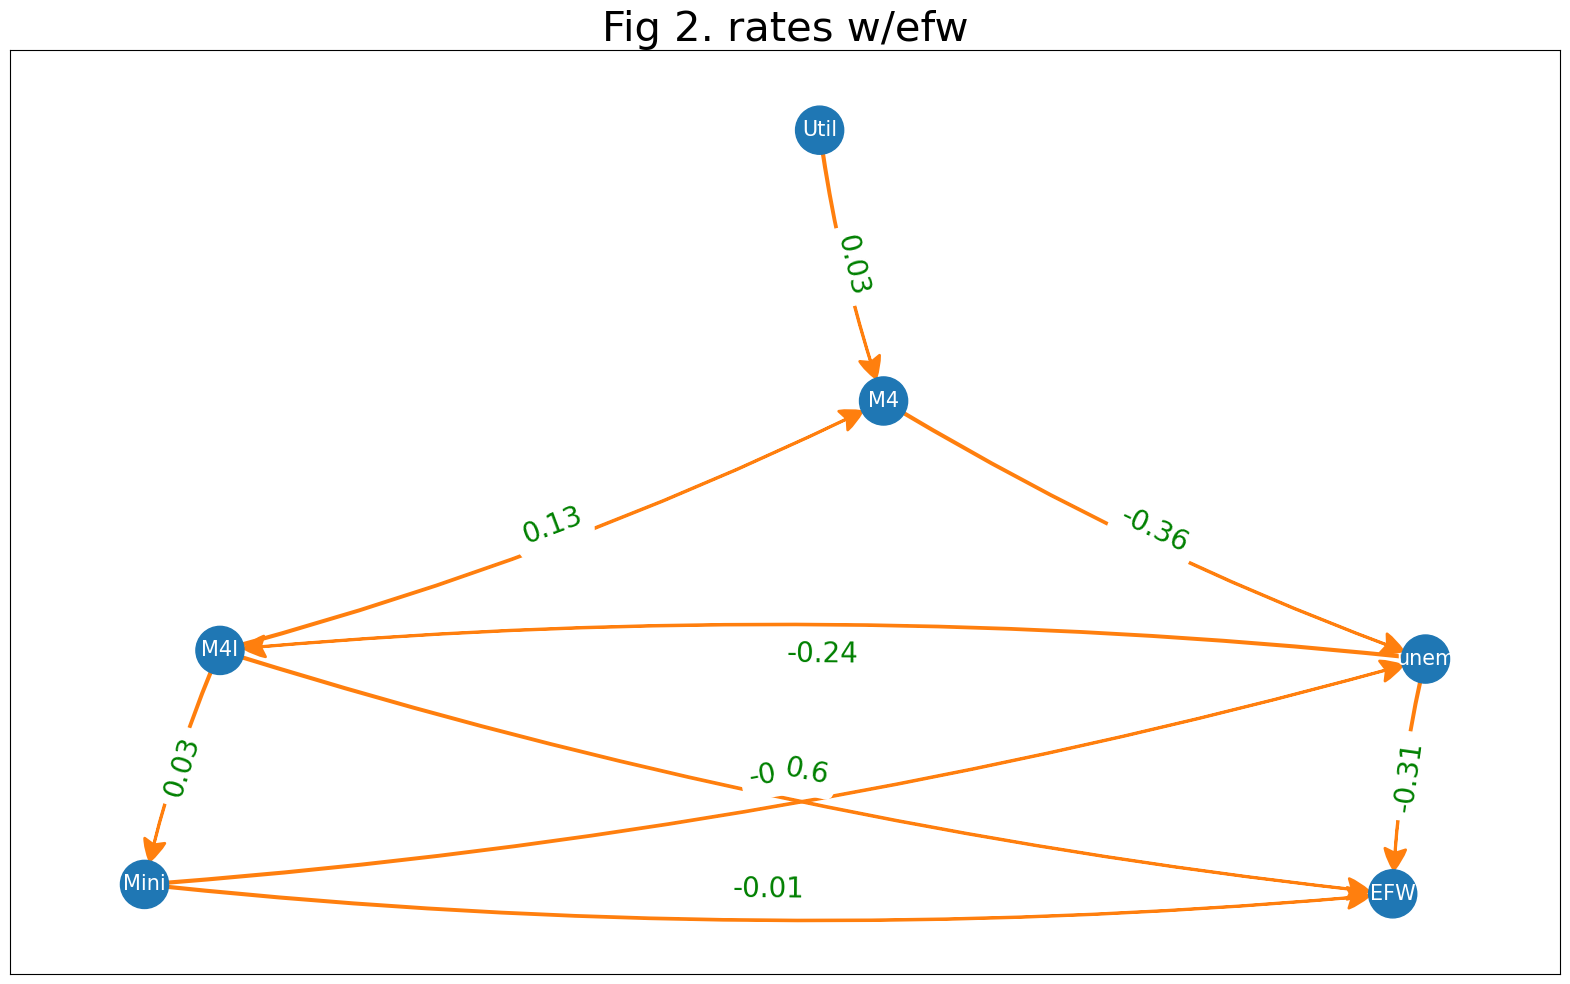

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


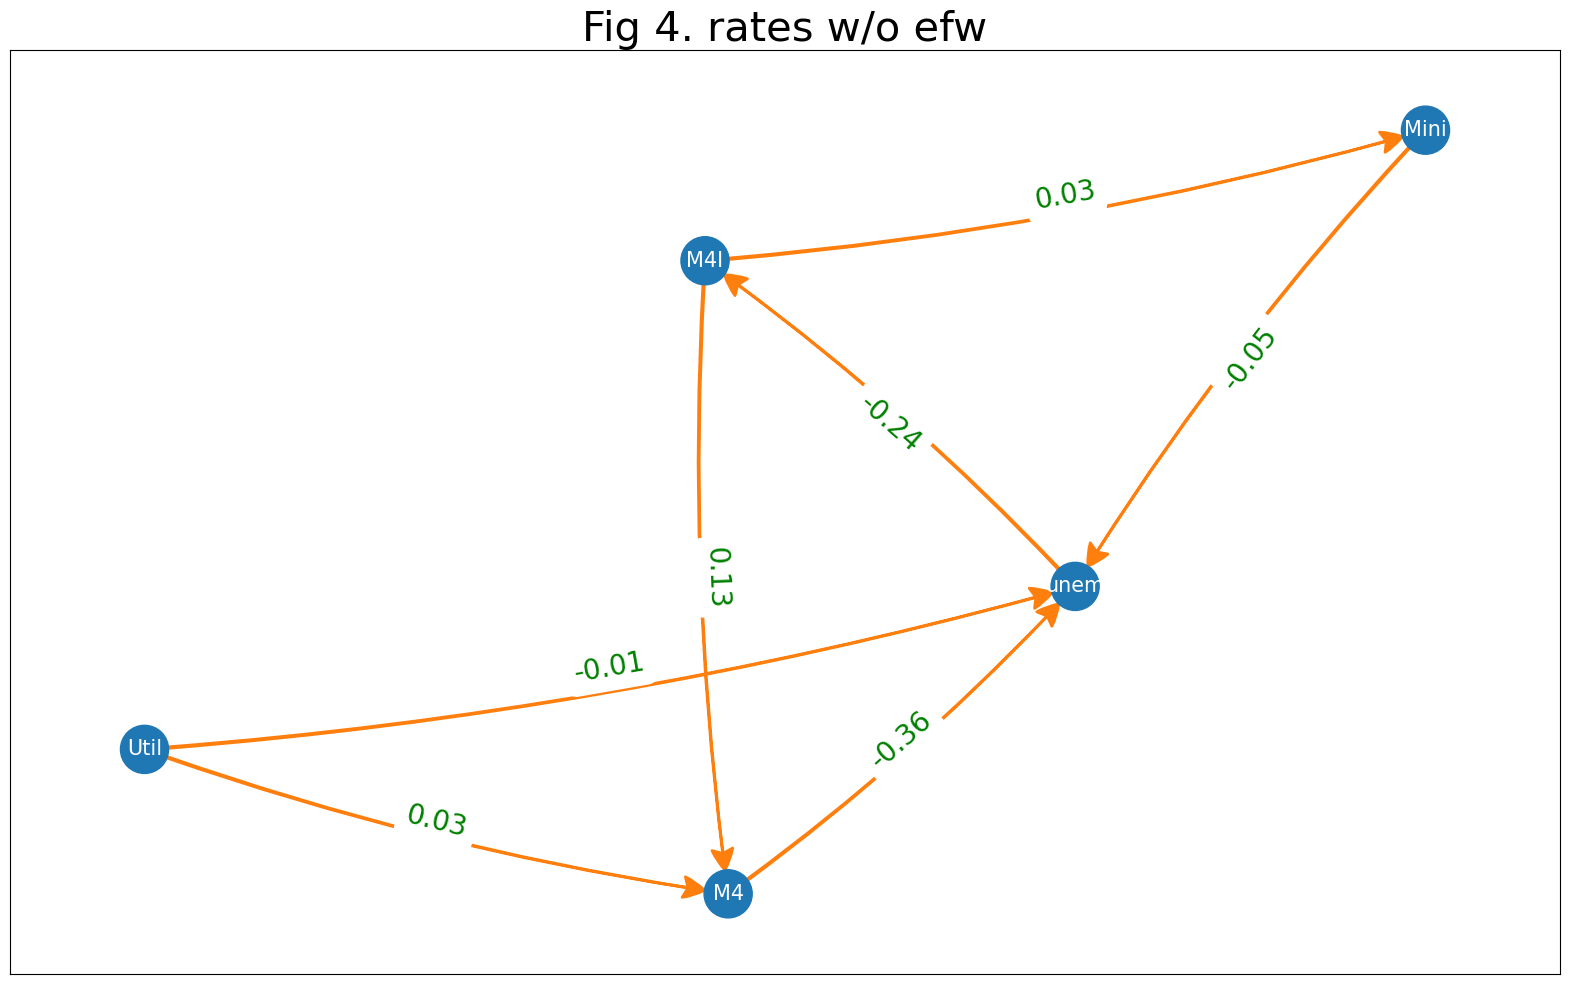

  0%|          | 0/5 [00:00<?, ?it/s]

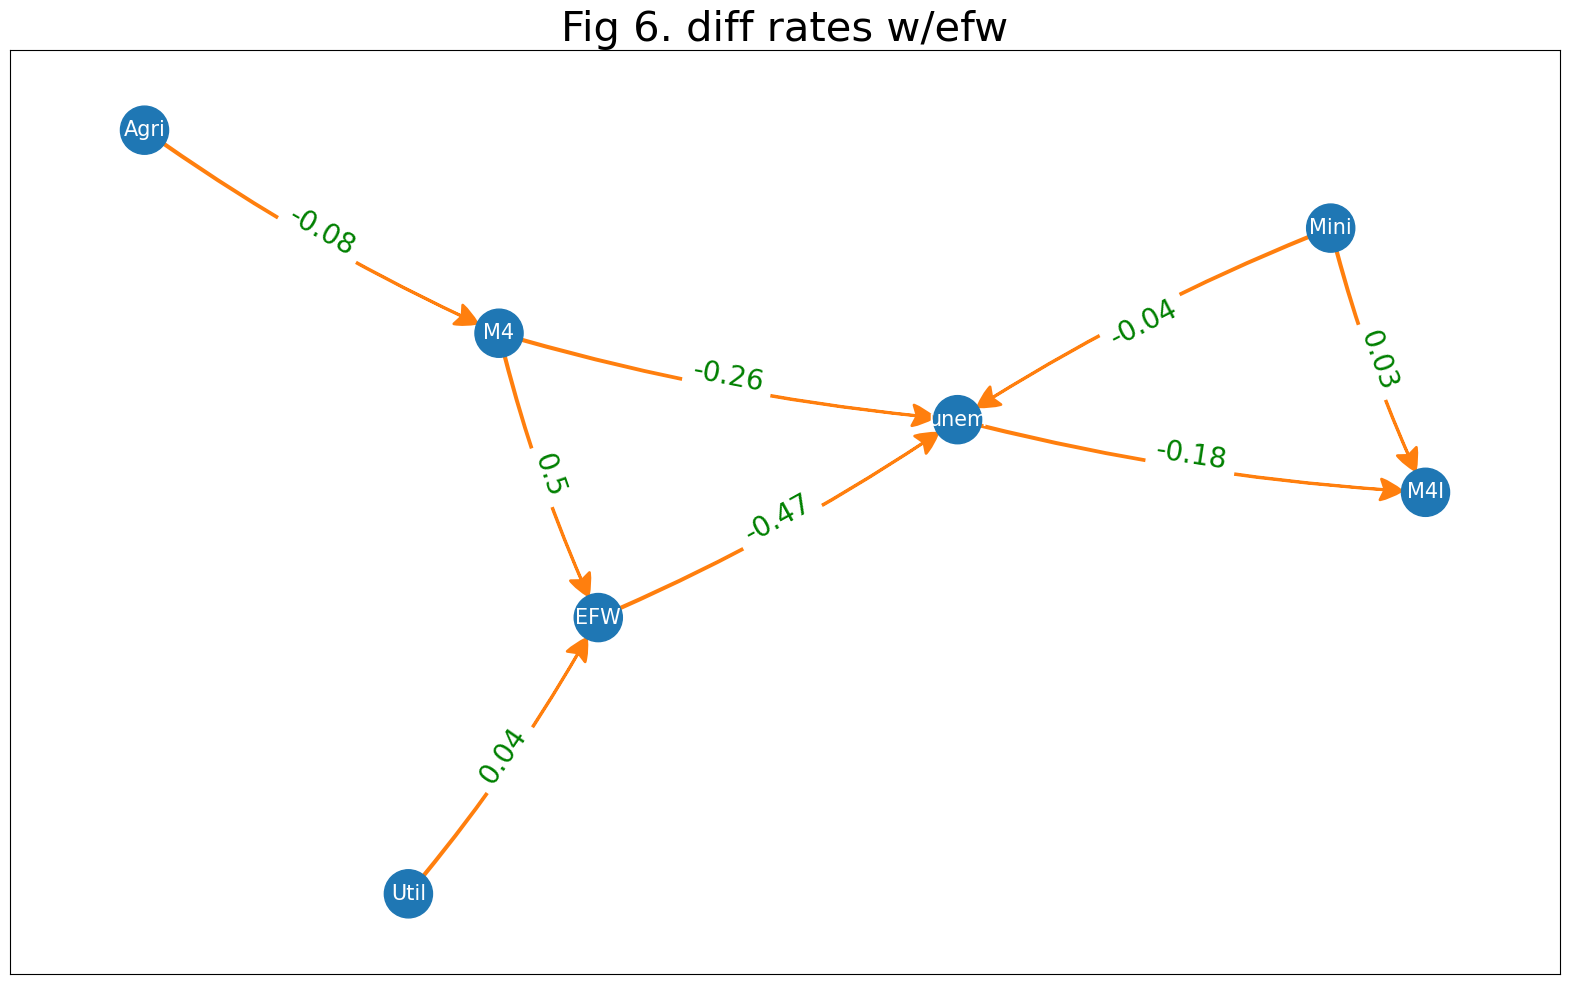

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


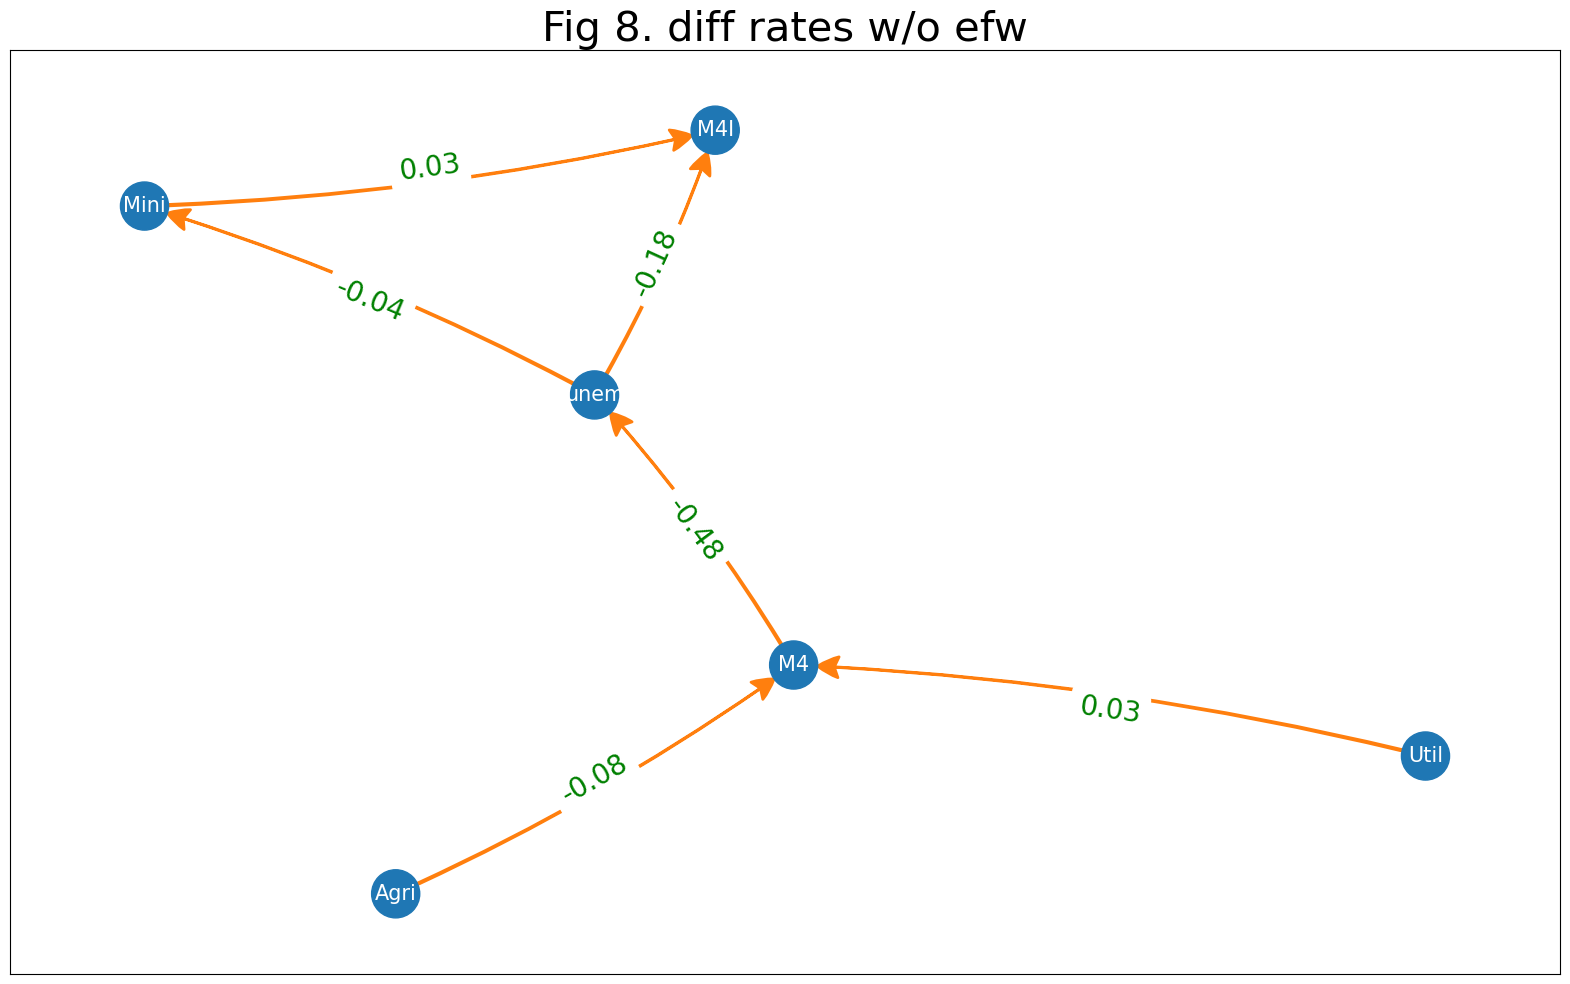

In [43]:
# Plot DAGs for full dataframe
save_directory = "Plots"


plot_graph(dataframes_dict, figsize_dict=(24, 20), p_val=0.01, overall_title='', save_dir=save_directory)


In [32]:
# Save train and test data 
train_data_rates_ols_efw, test_data_rates_ols_efw = get_best_fold_data_merged(best_rates_data_ols, 'const',
                                                                              'Agri',
                                                                             'Mini',
                                                                             'Util',
                                                                             'EFW',
                                                                             'M4',
                                                                             'M4I')

train_data_rates_ols_no_efw, test_data_rates_ols_no_efw = get_best_fold_data_merged(best_rates_data_ols, 'const',
                                                                              'Agri',
                                                                             'Mini',
                                                                             'Util',
                                                                             'M4',
                                                                             'M4I')

train_data_rates_wls_efw, test_data_rates_wls_efw = get_best_fold_data_merged(best_rates_data_wls, 'const',
                                                                              'Agri',
                                                                             'Mini',
                                                                             'Util',
                                                                             'EFW',
                                                                             'M4',
                                                                             'M4I')

train_data_rates_wls_no_efw, test_data_rates_wls_no_efw = get_best_fold_data_merged(best_rates_data_wls, 'const',
                                                                              'Agri',
                                                                             'Mini',
                                                                             'Util',
                                                                             'M4',
                                                                             'M4I')

train_data_diff_rates_ols_efw, test_data_diff_rates_ols_efw = get_best_fold_data_merged(best_diff_rates_ols,
                                                                             'Agri',
                                                                             'Mini',
                                                                             'Util',
                                                                             'EFW',
                                                                             'M4',
                                                                             'M4I')

train_data_diff_rates_ols_no_efw, test_data_diff_rates_ols_no_efw = get_best_fold_data_merged(best_diff_rates_ols,
                                                                             'Agri',
                                                                             'Mini',
                                                                             'Util',
                                                                             'M4',
                                                                             'M4I')

In [33]:
drop_cols = ['const']

test_data_rates_ols_efw.drop(columns=drop_cols, inplace=True)
test_data_rates_ols_no_efw.drop(columns=drop_cols, inplace=True)
test_data_rates_wls_efw.drop(columns=drop_cols, inplace=True)
test_data_rates_wls_no_efw.drop(columns=drop_cols, inplace=True)

train_data_rates_ols_efw.drop(columns=drop_cols, inplace=True)
train_data_rates_ols_no_efw.drop(columns=drop_cols, inplace=True)
train_data_rates_wls_efw.drop(columns=drop_cols, inplace=True)
train_data_rates_wls_no_efw.drop(columns=drop_cols, inplace=True)

In [44]:
k_fold_test_data = {}

k_fold_test_data['k-fold rates ols w/efw'] = test_data_rates_ols_efw
k_fold_test_data['k-fold rates ols w/o efw'] = test_data_rates_ols_no_efw
k_fold_test_data['k-fold rates wls w/efw'] = test_data_rates_wls_efw
k_fold_test_data['k-fold rates wls w/o efw'] = test_data_rates_wls_no_efw
k_fold_test_data['k-fold diff rates ols w/efw'] = test_data_diff_rates_ols_efw
k_fold_test_data['k-fold diff rates ols w/o efw'] = test_data_diff_rates_ols_no_efw

k_fold_train_data = {}

k_fold_train_data['Fig 1. k-fold rates w/efw'] = train_data_rates_ols_efw
k_fold_train_data['Fig 3. k-fold rates w/o efw'] = train_data_rates_ols_no_efw
k_fold_train_data['k-fold rates wls w/efw'] = train_data_rates_wls_efw
k_fold_train_data['k-fold rates wls w/o efw'] = train_data_rates_wls_no_efw
k_fold_train_data['Fig 5. k-fold diff rates w/efw'] = train_data_diff_rates_ols_efw
k_fold_train_data['Fig 7. k-fold diff rates w/o efw'] = train_data_diff_rates_ols_no_efw


  0%|          | 0/5 [00:00<?, ?it/s]

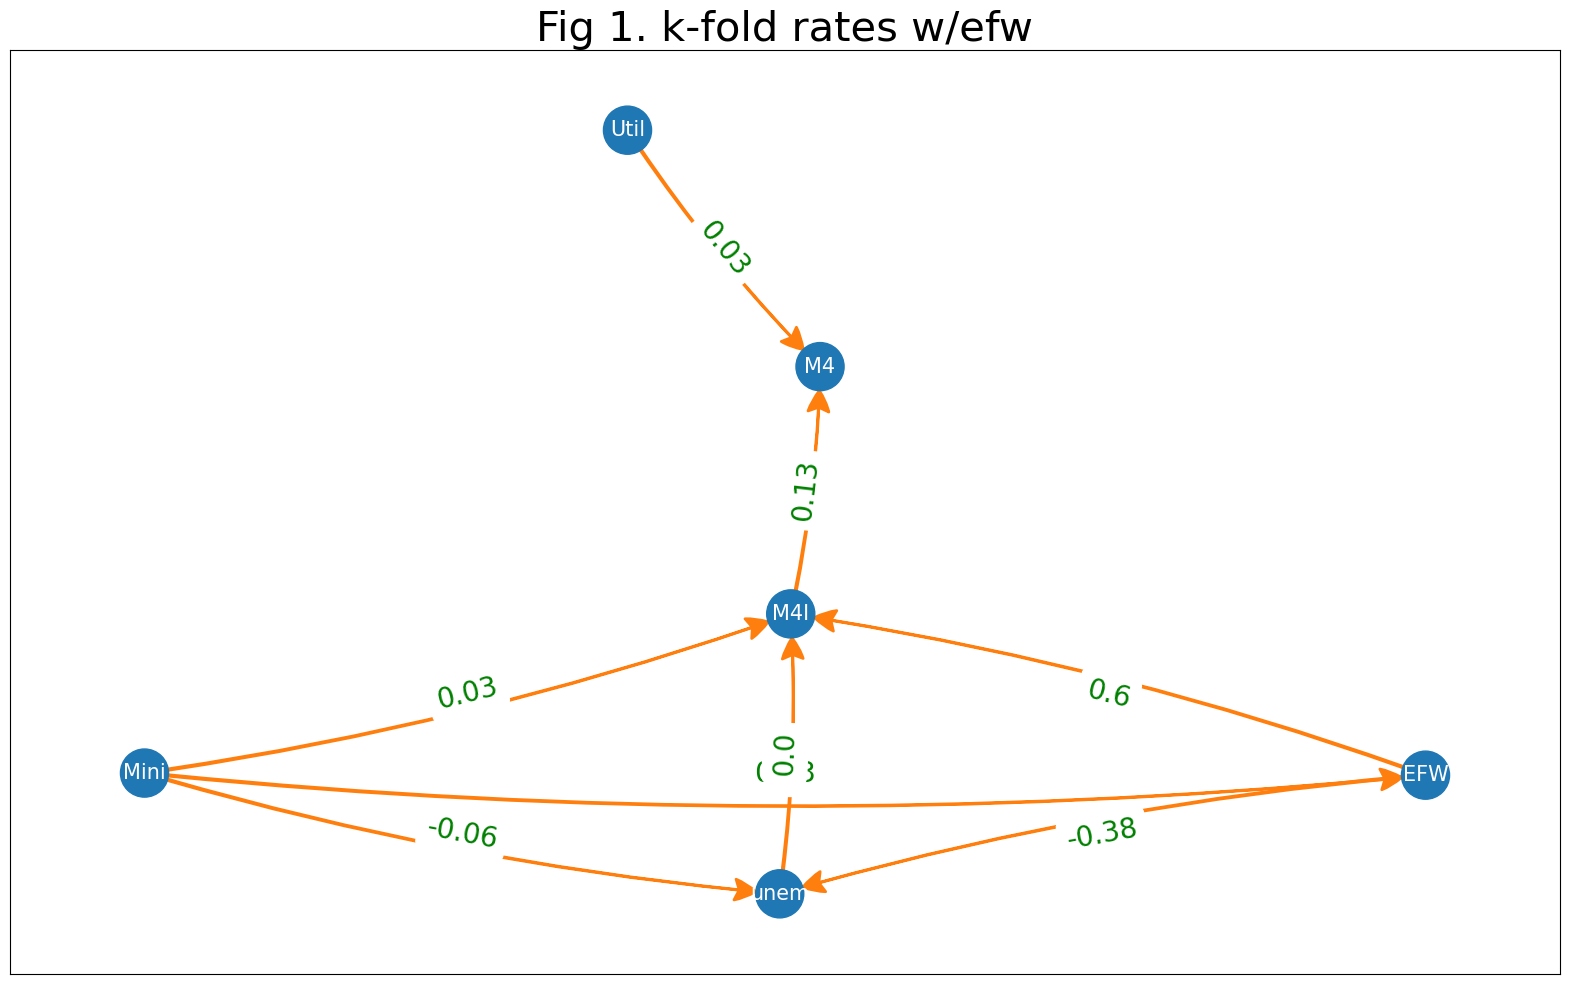

  0%|          | 0/4 [00:00<?, ?it/s]

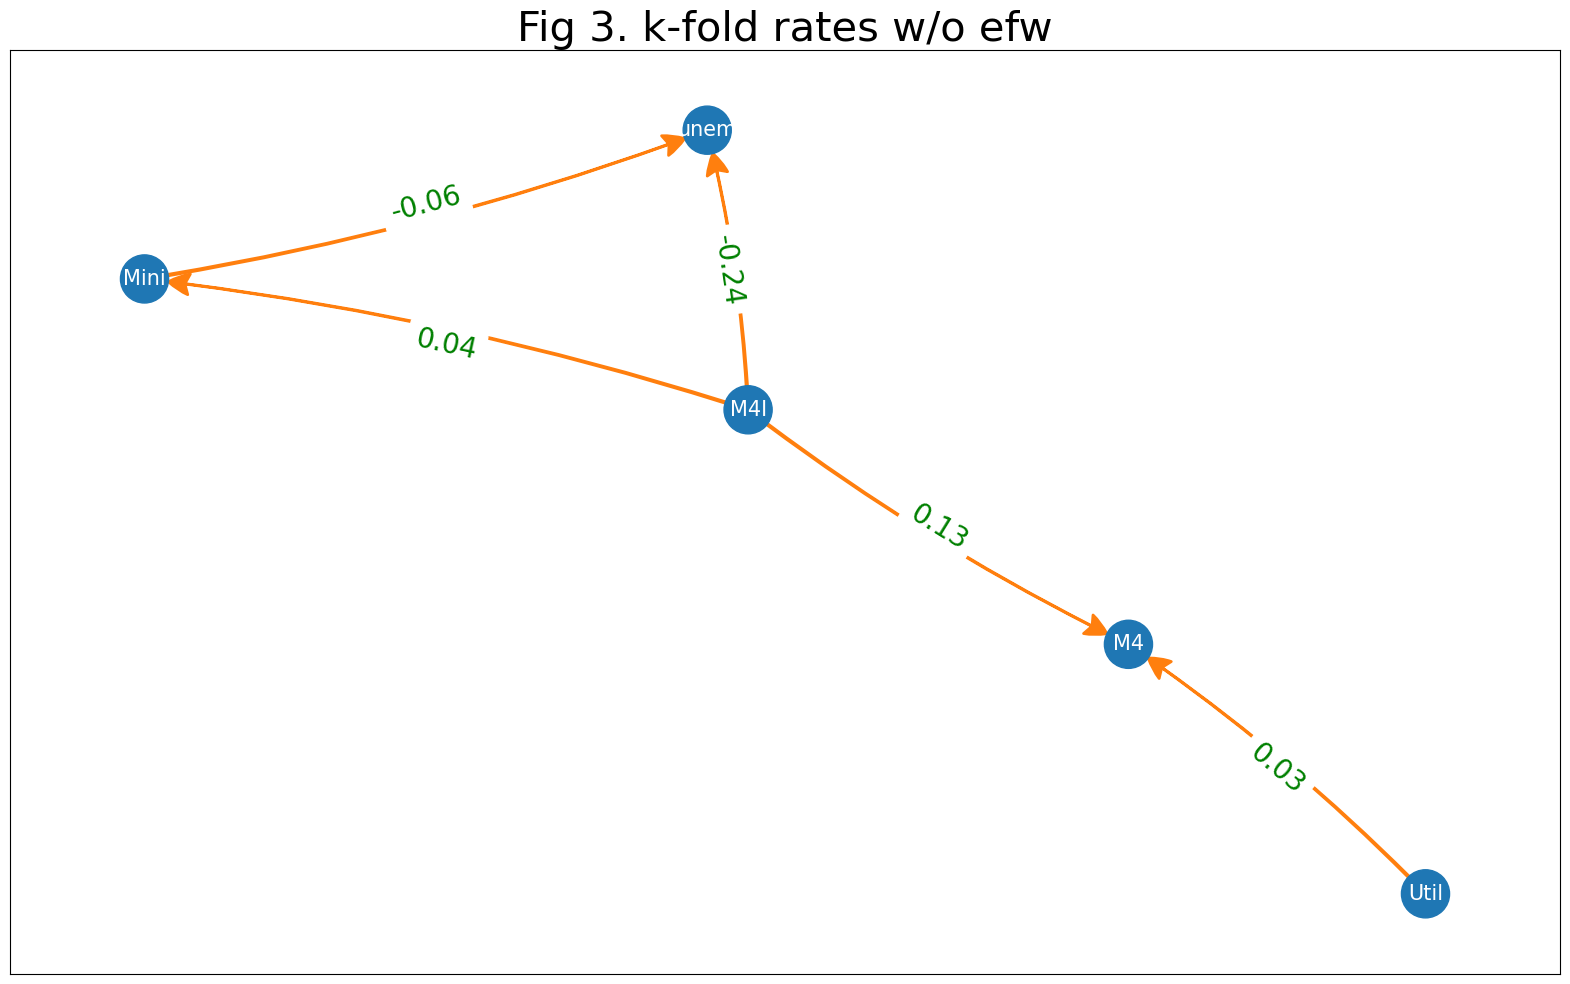

  0%|          | 0/5 [00:00<?, ?it/s]

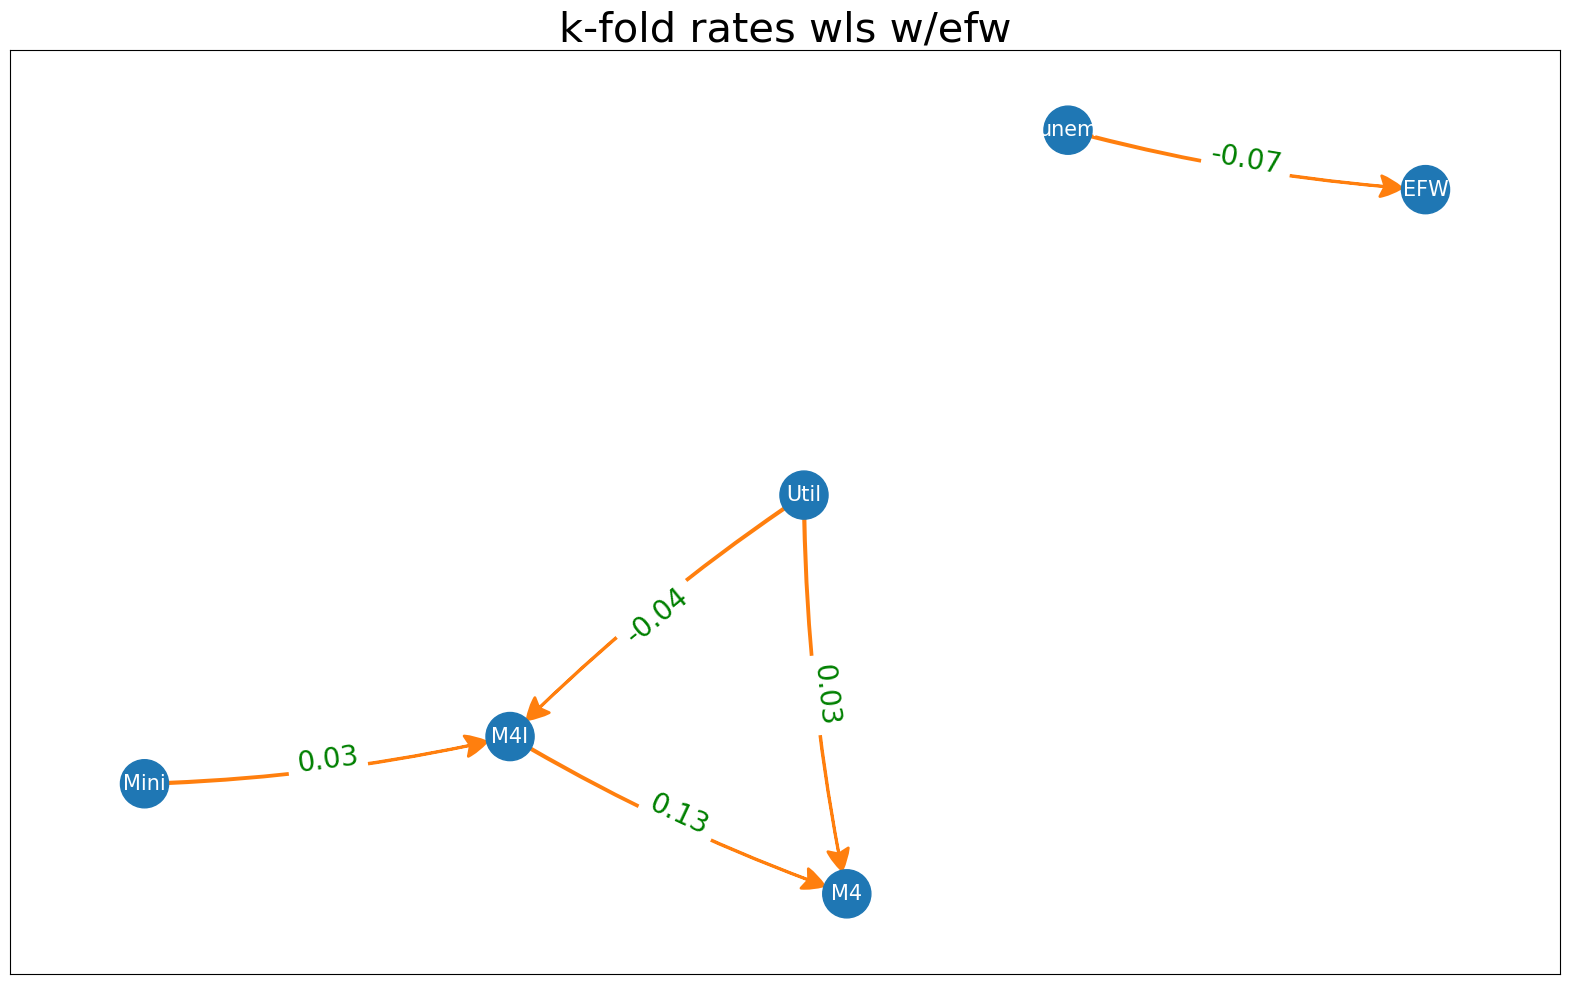

  0%|          | 0/4 [00:00<?, ?it/s]

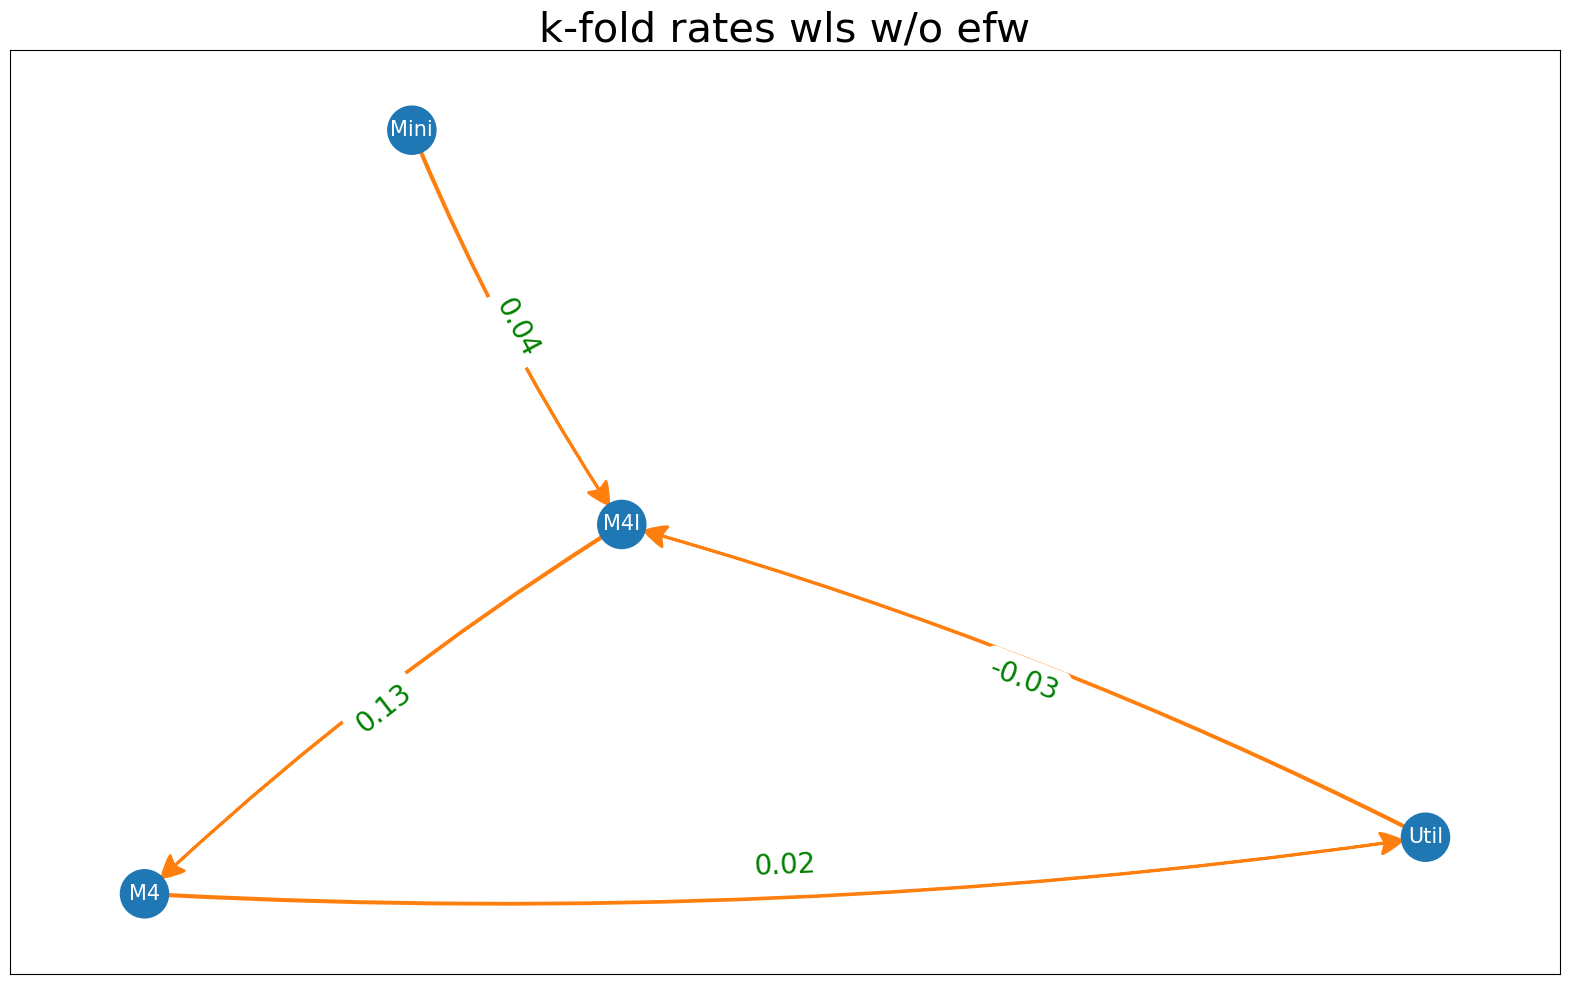

  0%|          | 0/5 [00:00<?, ?it/s]

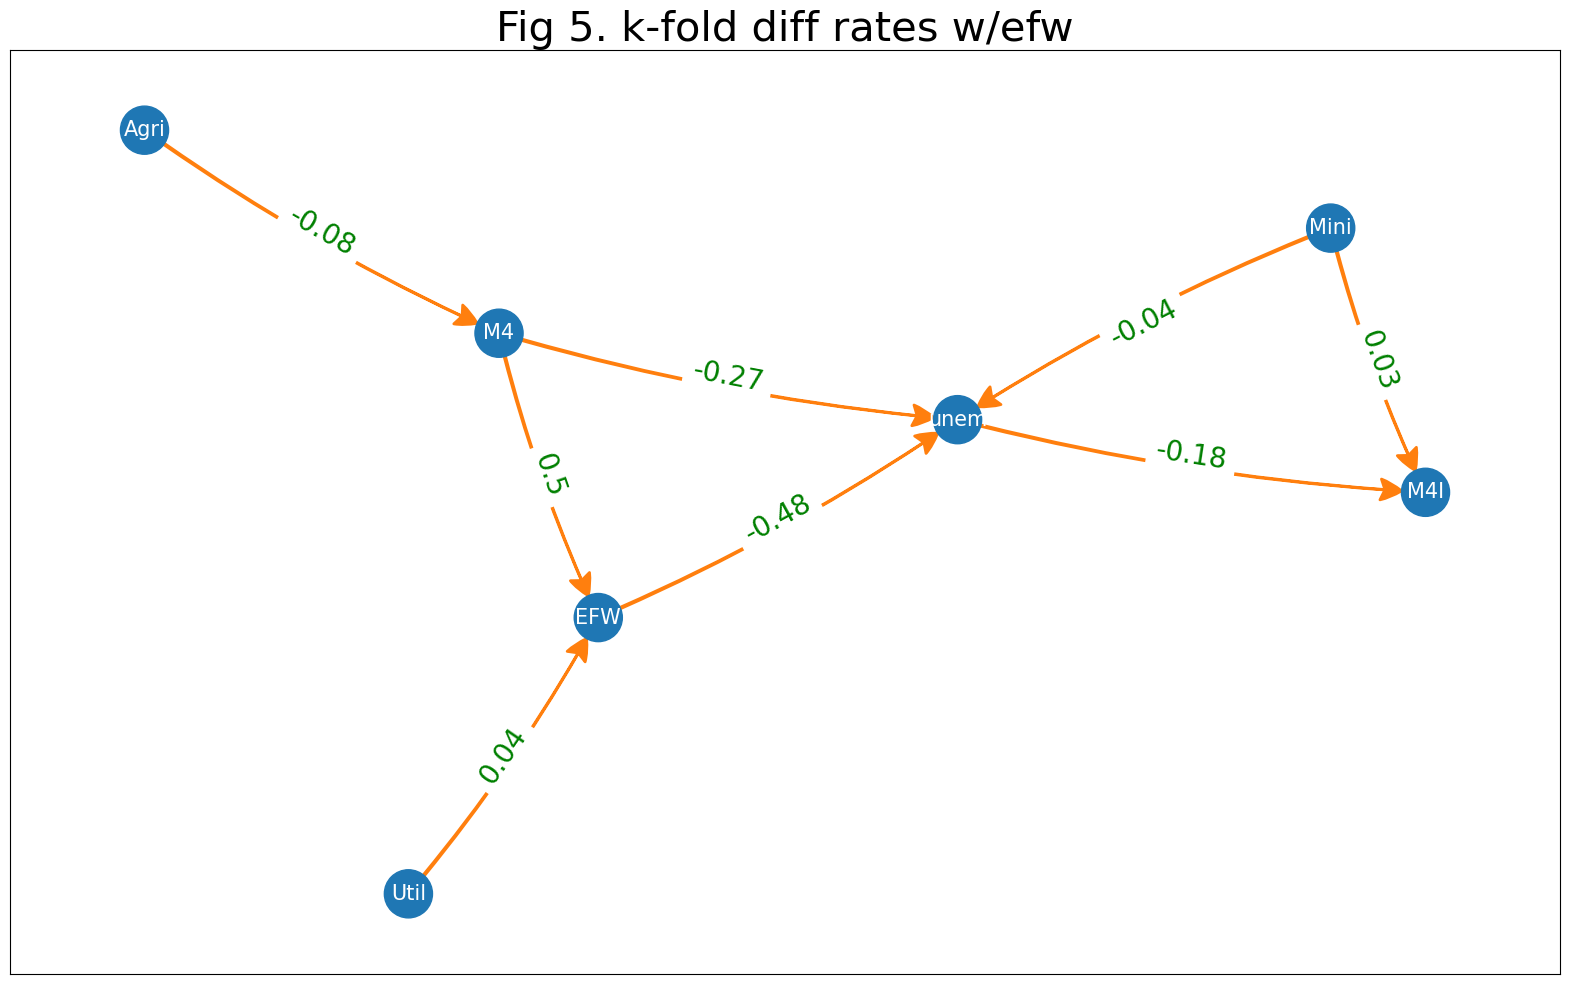

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


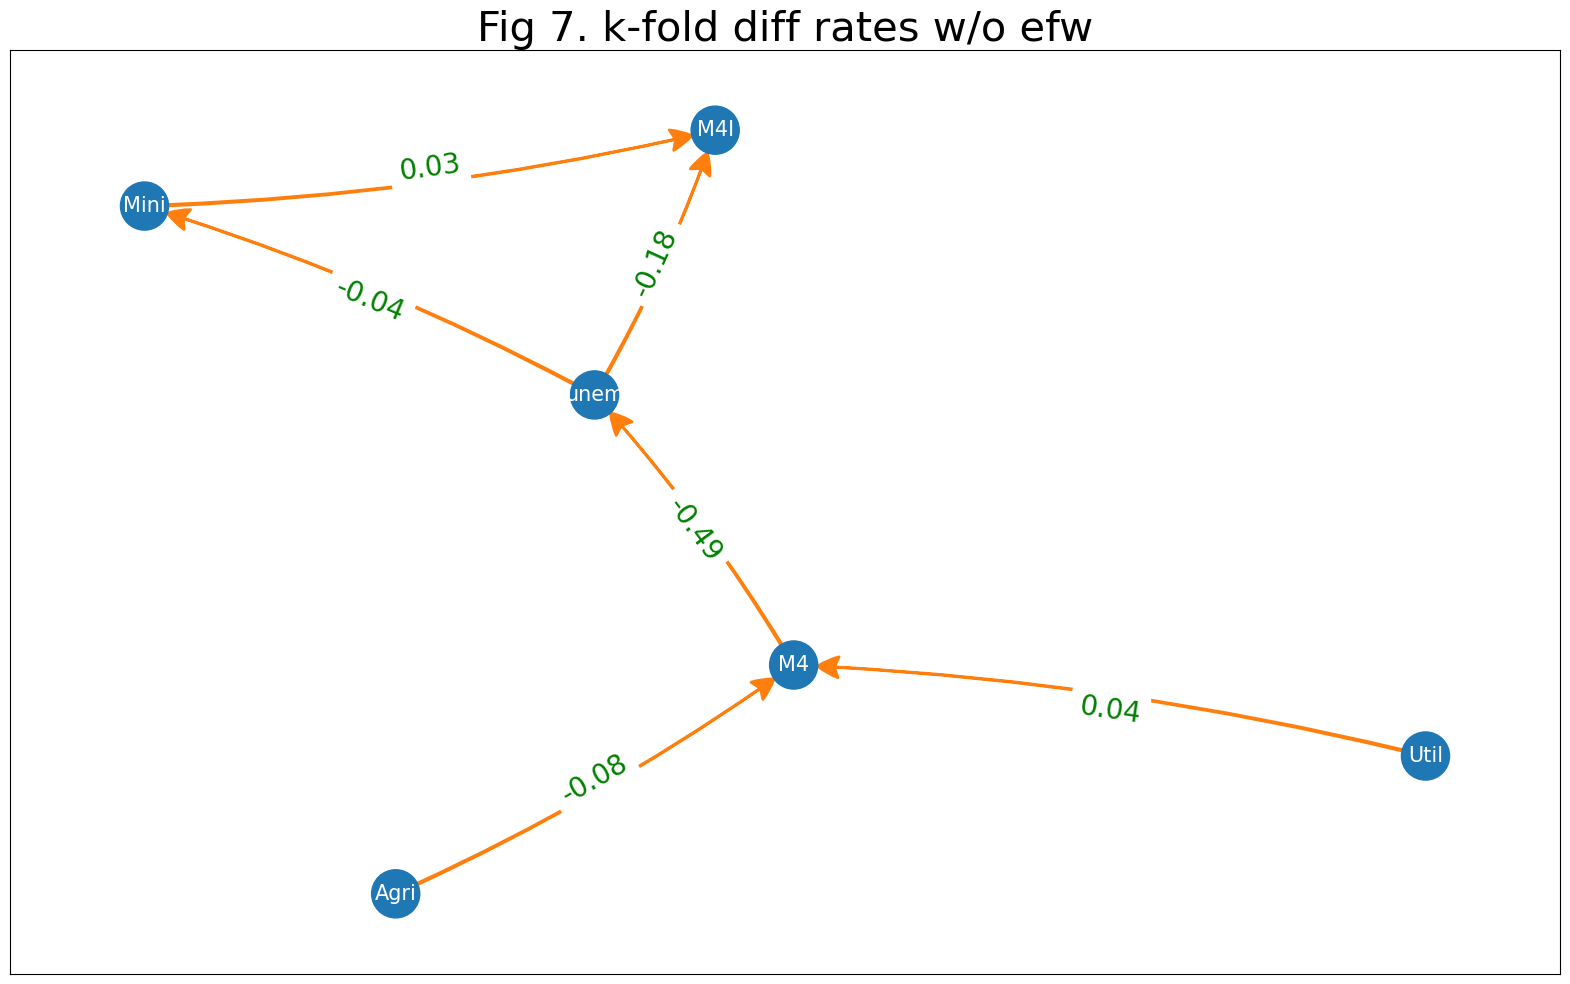

In [45]:
# Plot DAGs for k-fold data
save_directory = "Plots"

plot_graph(k_fold_train_data, figsize_dict=(24, 20), p_val=0.01, overall_title='', save_dir=save_directory)


In [36]:
combined_summary = combined_summary.round(2)

In [37]:
# Convert DataFrame to HTML table
table_html = combined_summary.to_html(index=True, border=0, classes='dataframe', justify='center')

display(HTML(table_html))

In [40]:
import os
from IPython.core.display import display, HTML

# Specify the directory containing your images
image_directory = "plots"

# List the specific images you want to include
selected_images = ["rates_w_efw_w_o_clusters.png", "rates_w_o_efw_w_o_clusters.png", 
                   "diff_rates_w_efw_w_o_clusters.png", "diff_rates_w_o_efw_w_o_clusters.png"]


# Capital Theory and Analysis

## Capital Theory

Capital theory is a vast topic in finance and there still seems to be the argument as to what capital means and what it should truly mean. Neoclassicals define capital as a physical quantity that is independent of prices (Robinson, 1970). Historically, the definition of capital has been often shifting from either financial or physical. It started as being financial, in that it meant the sum of all money equivalent of all assets minus the sum of the money equivalent of all liabilities at a particular date to the conduct of the operations of a specific business unit (Lewin and Cachanosky, 2019). After a while economists argued that capital could not be defined as being financial only, and that birthed the physical aspect of capital referred to as physical capital. This connotes the set of physical production goods (often referred to as capital goods). In recent times, capital theorists began to take a look at how time could have an effect on capital as a whole, thus, illustrating capital in terms of having three different but inseparable dimensions: value, quantity and time. What this means is that capital can be viewed as financial, physical and yet involving time in a particular business process. Various disciplines have various definitions for capital, for example, Bourdieu’s capital theory recognizes that capital does not necessarily need to be economic but also includes other factors such as social and cultural capital (Bourdieu, 1986). Lewin and Cachanosky (2019) indicate that capital can be understood as the money value of a firm which accounts for all assets and liabilities. Stating that “productive activities employ stocks of durable and nondurable productive resources over time to produce a flow of valuable products or services for use or for sale”. The value of capital is based on the production process over time and the value of its finished goods or services. Interestingly, developed nations in recent years are beginning to experience a rise in the importance of intangible capital (such as information technology) in production and a decline in the reliance on physical capital (Caggese and Perez-Orive, 2022).

Interest rates as well as foreign exchange rates play a vital role in transmitting distortions to the capital structure of economies. Low interest rates do not accommodate for intangible investments due to the nature of intangible capital financing eventually resulting in consequences for aggregate capital misallocation. (McKinnon, 2010; Cachanosky, 2014; Caggese and Perez-Orive, 2022).

According to Caggese and Perez-Orive (2022), the reaction of tangible and intangible firms to interest rate changes differ, in that increases in interest rates negatively affects investment of tangible firms. This is expected as conventional theories would rightly predict. However, the investment of intangible firms reacts positively to increases in interest rates.

## Capital Structure

To explain the combination of security and financial sources used by a corporation, various hypotheses have surfaced. Following the foundational paper by Modigliani and Miller (1958), which raised the problem of the relationship between a firm's choice of finance and its value, the financing choice of firms is, in fact, possibly the most investigated topic area in finance in recent decades. Although there isn't a single, widely recognized explanation describing why companies choose between debt and equity, various theories have surfaced in the previous few decades. These theories have considered macroeconomic variables as well as firm level characteristics in particular.

Modigliani and Miller (1963) suggest that firms may prefer debt over equity due to tax advantages, potentially leading to high debt levels for profitable firms. However, Miller (1977) and others note the impact of personal taxation, and DeAngelo and Masulis (1980) argue that firms with other tax shields may not prioritize interest tax shields.

Myers and Majluf (1984) propose the pecking-order theory, suggesting that firms, due to information asymmetry, prefer internal funding over external sources. Thus, profitable firms may use retained earnings for investments rather than debt. Rajan and Zingales (1995) find support for this theory, showing a negative correlation between leverage and profitability.

Rajan and Zingales (1995), following Bradley et al. (1984) and Titman and Wessels (1988), find a positive relationship between tangibility (ratio of fixed to total assets) and leverage. They suggest that firms with more collateral may find it easier to secure debt, aligning with the ideas of Scott (1977), Williamson (1988), and Harris and Raviv (1990) on reducing agency problems.

## Demand Shocks

Demand shocks are typically caused by changes in consumer preferences, economic policies, or external factors such as changes in the global economy (Kilian, 2008). The most common example of a demand shock is a sudden change in consumer demand for a product or service (Kilian and Hicks, 2013; Leduc and Lui, 2016). This can lead to a decrease or increase in the level of production of the product, depending on whether the demand shock is positive or negative (Ball et al., 1995; Berument et al., 2010; Kiss et al., 2023). According to the conventional theory of growth and fluctuations, aggregate demand results in temporary deviations from a production trend that is solely influenced by supply forces (capital accumulation, labor force growth and technological progress). After a shock, the economy returns to its typical output path: In the words of the empirical research on growth and economic fluctuations, GDP is "trend steady". In the literature on real business cycles, deviations from trend can be long-lasting, but this is typically read as indicating that supply-side variables, such as technological shocks, dominate fluctuations in the economy (Kilian and Park, 2009). The topic of whether aggregate demand shocks have long-lasting, irreversible consequences on output and living standards thus appears to be answered negatively by orthodox economic theory, with few exceptions (Bachmann, et al., 2013; Dutt and Ros, 2003; Dutt and Ros, 2007). Economic growth may be permanently impacted by aggregate demand. As a result of rising returns, hysteresis impacts in labor markets, and balance of payments limitations, it is demonstrated that even if the economy converges to some "normal" route, this course could still be changed by significant demand shocks. It is also demonstrated that the economy might not follow its "normal" trend, in which case fiscal and monetary policy will affect output and growth over the long run (Dutt and Ros, 2007; Kilian, 2009).

## Supply Shocks

Changes in the availability or price of a crucial input in the production process are frequently what trigger supply shocks (Reifschneider et al., 2015). They are unexpected events that cause a sudden change in the availability of a key input or resource in the production process, leading to changes in the overall cost structure of firms (Ecstein and Sinai, 1986). These shocks can have a significant impact on the economy, with implications for production, employment, and inflation.

Raw material, energy, or labor price increases are the most typical types of supply shocks (Blinder et al., 2013; Bruno and Sachs, 1982). When businesses are unable to generate as much output as before, a sudden increase in the price of an input might result in a drop in the supply of the product being produced (Eckstein and Sinai, 1986; Fisher et al., 1994).

The relationship between supply shocks and pricing in the production structure has been the subject of numerous researches. For instance, a study by Blanchard and Fischer (1989) contends that positive supply shocks can boost a firm's production capacity, resulting in higher output and reduced inflation. These shocks include drops in the price of oil or advances in technology. On the other hand, negative supply shocks, such as abrupt rise in oil costs or a natural disaster, can cause output to fall and prices to rise. The impact of shocks in supply-side policies, such as tax incentives and deregulation, on productivity and efficiency can have long-term effects on production structure by influencing investment decisions, technology adoption, and competition (Jorgenson, 1991).

## Models of Demand and Supply shocks on production structure

One of the most prominent theories on the impact of supply and demand shocks on production structure is the Input-Output (IO) framework (Gilmartin et al., 2008; West, 1995), which is based on the idea that different sectors of the economy are interconnected through their use of intermediate inputs. The IO framework can be used to analyze the impact of supply and demand shocks on the production structure by tracing the flow of inputs and outputs through different sectors of the economy (Li et al., 2018). IO model was used to study the impact of Chinese import competition on US manufacturing and the study found that Chinese imports led to a decline in demand for US-manufactured goods, which in turn led to a decline in the number of firms and workers in the sector (Acemoglu et al., 2016; Autor et al., 2013).

Another approach to studying the impact of supply and demand shocks on the production structure is through the use of computable general equilibrium (CGE) models. These models are used to analyze the impact of changes in supply and demand on the economy as a whole, by considering the interactions between different sectors and households (Blake et al., 2001; Diao and Thurlow, 2012; Doroodian and Boyd, 2003; Seung and Water, 2010). One study on macroeconomic and distributional consequences of energy shocks utilized this model and showed that oil supply shocks are costly and result in a decline in real GDP, higher average prices and increase balance of payment deficits (Adenikinju and Falobi, 2006).

More generally, supply and demand shocks can have significant impacts on the production structure, with the magnitude and direction of the impact depending on a range of factors, including the initial structure of the economy, the nature of the shock, and the policy response. While different models have accessed the impacts and possible directions of demand and supply shocks, there is little to no research using a directed acyclic graph to model the impact of demand and supply shocks on a production structure.

## Money Supply

The importance of monetary policy measures as a means to increase firms' access to debt funding has been underlined by the recent Global Financial Crisis. In the midst of the crisis, central banks in most advanced economies have carefully examined the possibility of buying public and private debt to increase credit and money supply (Epstein1, 2007; El-Erian, 2017; Julio et al., 2020).

Corporate capital structure is likely to depend on decisions made by monetary authorities given the role of monetary policy in achieving financial stability (Ashcraft et al., 2011; Stein, 2012) and the idea that a more stable environment should support company operations. To the degree that borrowing restrictions affect business cycles and collateral values, it is widely recognized that monetary policy can impact bank lending and real activity (Lacoviello, 2005; Gilchrist and Zakrajsek, 2011; Stein, 2012).

According to Pindado et al., (2020), there exists a nonlinear relation between money growth and corporate debt stating that the relation exhibits an inverted U-shape. An increase in the money supply facilitates firms’ indebtedness because of the higher liquidity in the market (Holmstrom and Tirole, 1998; Schnabl, 2012; Dewally and Shao, 2014; Pindado et al., 2020). However, there is an optimal level beyond which additional growth of the monetary aggregate has the opposite effect. From this level onwards, further expansionary measures discourage firms from borrowing because of the risk of inflation, which would in turn lead to increases in interest rates, making debt more expensive (White, 2009; Bordo and Landon-Lane, 2013; Pindado et al., 2020). Nevertheless, the characteristics of the banking system influence the intensity of the effect of money supply on firm debt and determine the level of growth of the monetary aggregate that is necessary to maximize firms’ access to debt financing (Becker and Ivashina, 2014). If there is higher liquidity in the hands of banks, the impact of expansionary measures on debt is mitigated and the inflection point at which the relation between both factors turns from positive to negative is reached at a higher level (Eichengreen, 2004; White, 2009). By contrast, in countries where banks allocate a higher fraction of their resources to private credit, the effect of the monetary aggregate on debt is more pronounced, reducing the amount of money supply that is necessary to maximize corporate leverage (Bolton and Freixas, 2006; Kashyap et al., 2008; Crouzet, 2018).

According to Chung and Ariff (2016) and Urbanovský (2016), there is not yet a consensus in empirical research supporting Friedman's proposition that "increases in money supply should lead to liquidity surges and credit expansion." Friedman (1968) argued that a gradual increase in the money supply is essential for a healthy economy as it stimulates economic growth. Therefore, since various sector of an economy’s growth is often indicative of aggregate economic growth, it is possible that the money supply directly influences these sectors or acts as a moderator for the impact of microeconomic variables on the global market (Otambo, 2016; Egbunike and Okerekeoti, 2018). Additionally, Singh, Mehta, and Varsha (2011) suggested that including macroeconomic variables in investment decision-making could enhance investors' ability to develop profitable investment strategies thus, creating a growth in the economy.


In recent years, researchers have increasingly focused on how the external macroeconomic environment influences a firms' capital structure (Bokpin, 2009; Kumar et al., 2017; Dong, 2023). Korajczyk and Levy (2003) investigated this relationship and discovered that firms without financing constraints tend to prefer equity financing during economic expansions, whereas they favor debt financing during contractions. Conversely, firms facing financing constraints exhibit the opposite pattern. This highlights the significant impact of the macroeconomy on firms' capital structure. Hackbarth et al., (2006) further emphasized the importance of capital supply shocks, whether from the credit or capital markets, in shaping firms' capital structure. Kashyap et al., (1993) observed that tight monetary policy leads to changes in firms' external financing behavior, resulting in a significant decrease in the amount of bank loans obtained by firms. The influence of macroeconomic conditions on capital structure exhibits distinct patterns: firms without financing constraints demonstrate counter-cyclical changes in their target leverage, whereas constrained firms show cyclical changes (Leary, 2009).

There is little empirical data examining the impact of money supply and demand shocks on firms’ capital structure. The majority of research considers macroeconomic factors as relatively stable external conditions influencing corporate financing decisions. These studies either aim to manage macroeconomic disturbances or seek to explain variations in capital structure from a microeconomic perspective. For instance, Dongwei and Haihua (2009) analyzed China's capital structure using macroeconomic factors and discovered an inverse relationship between China's capital structure and economic cycles. A more recent study carried out by Dong (2023) which examined the correlation between money supply and corporate capital structure through the lens of financial constraints discovered that there is a significant and positive relationship between money supply and corporate capital structure when financing constraints are not considered. Dong also found that the impact of money supply on capital structure differs among firms with varying degrees of financing constraints, with firms facing higher financial constraints experiencing a significantly stronger effect compared to those with lower constraints. However, there still remains a gap in the literature regarding the effects of a demand and/or supply shock of money supply to the capital structure of a firm.

## Research Hypothesis

$H_1$ : There is a positive correlation between money supply and production economy

$H_2$ : An increase in interest rates results in a decrease in the production

$H_3$ : Increase in money supply results in decrease in unemployment rates

$H_4$ : There exists a positive correlation between interest rates and unemployment rates

$H_5$ : The higher the economic freedom, the lower the unemployment rates and the higher the nominal GDP

## Results

### Directed Acyclic Graphs (DAGs)
    
The provided Directed Acyclic Graphs (DAGs) visually depict relationships between variables influencing unemployment, used as a proxy for capital structure. These graphs provide insights into how sectoral factors, macroeconomic indicators, and Economic Freedom Index (EFW) interact to shape unemployment rates. The graphs analyze each configuration (rates vs. differenced rates, with/without EFW, k-fold/full models) relative to demand and supply shocks to the capital structure.
    
#### Rates with EFW
    
![Fig 1](Plots/Fig_1._k-fold_rates_w_efw.png) ![Fig 2](Plots/Fig_2._rates_w_efw.png)

##### K-fold Model


In this DAG (Fig 1), unemployment rates (unem) is influenced directly by mining (Mini), M4I, and EFW. There are indirect paths through M4 (money supply), which aggregates the effects of utilities (Util) and interest rates (M4I). The negative path from EFW to unemployment (-0.38) indicates that higher economic freedom reduces unemployment rates. This aligns with the notion that freer markets facilitate better resource allocation and labor flexibility, mitigating the impact of supply shocks. Utilities (Util) positively affect M4 (coefficient of 0.03), which in turn positively influences M4I. This suggests that improved utility infrastructure indirectly tightens monetary policy, potentially curbing excessive liquidity that could destabilize capital structures. The strong negative association between M4I and unemployment highlights that tighter monetary policies reduce labor demand, exacerbating unemployment. This underscores the trade-offs in monetary policy: higher interest rates stabilize capital structures but at the cost of labor market rigidity.
    Demand shocks are evident in the positive path from M4 to unemployment, as excess liquidity can temporarily inflate demand but ultimately destabilize capital allocation. Supply shocks dominate through mining's direct negative effect on unemployment rate (-0.06), reflecting the sector's capital rigidity during downturns.
    
##### Full Model (Fig 2)
    
The structure mirrors the k-fold model but with stronger connections between EFW and unemployment (-0.31). This reaffirms the critical role of institutional factors in buffering supply constraints.
    
#### Rates without EFW

![Fig 3](Plots/Fig_3._k-fold_rates_w_o_efw.png) ![Fig 4](Plots/Fig_4._rates_w_o_efw.png)
    
##### K-fold Model
    
Here (Fig 3), unemployment is primarily influenced by M4I and mining, with indirect effects from M4 and utilities. EFW is excluded, narrowing the scope to direct economic mechanisms. Mining's paths to unemployment (-0.06) reveal its negative impact on unemployment. While increased mining activity can stabilize labor demand, supply disruptions lead to significant job losses, destabilizing capital structures. The positive effect between M4 and M4I (0.13) indicates that increased money supply tightens interest rates, suggesting monetary policy adjusts to maintain capital structure equilibrium.
    Demand shocks are reflected in the tight monetary adjustments from M4 to M4I, which prevent overexpansion of demand while supply shocks dominate in mining and utilities, where operational disruptions propagate through unemployment.
    
##### Full Model
    
The DAG (Fig 4) reinforces mining's role, with a direct negative effect on unemployment. Utilities remain a stabilizing factor through their indirect influence on M4.
    
#### Differenced Rates with EFW

![Fig 5](Plots/Fig_5._k-fold_diff_rates_w_efw.png) ![Fig 6](Plots/Fig_6._diff_rates_w_efw.png)

    
##### K-fold Model
    
Unemployment in this DAG (Fig 5) is influenced by agriculture, mining, M4I, and EFW. M4 mediates several indirect effects.
    Agriculture negatively affects M4 (-0.08), reducing money supply and tightening capital availability. This underscores agriculture's stabilizing role during demand shocks, where reduced liquidity tempers inflationary pressures. EFW's negative effect on unemployment (-0.47) is more pronounced than in the rates models, suggesting that institutional freedom plays a larger role in short-term labor market adjustments.
    Demand shocks are mitigated by agriculture and EFW, which enhance labor flexibility and temper excess liquidity. Supply shocks remain significant in mining (-0.04), where disruptions directly increase unemployment.
    
##### Full Model (Fig 6)
    
The structure amplifies agriculture's negative effect on unemployment, emphasizing its critical role in stabilizing demand disruptions.
    
#### Difference Rates without EFW

![Fig 7](Plots/Fig_7._k-fold_diff_rates_w_o_efw.png) ![Fig 8](Plots/Fig_8._diff_rates_w_o_efw.png)

    
##### K-fold Model
    
The DAG (Fig 7) excludes institutional factors, focusing on economic and sectoral variables. Unemployment is directly influenced by mining, agriculture, and M4I.
    M4 plays a central role, mediating between utilities and unemployment. The positive path from utilities to M4 (0.04) suggests that improved infrastructure stabilized monetary conditions, indirectly reducing unemployment. The strong negative path from M4I to unemployment (-0.18) reinforces the importance of interest rates in short-term labor market adjustments.
    Demand shocks are reflected in agriculture's stabilizing role and the tight monetary adjustments through M4I, while supply shocks remain significant, particularly in mining and utilities, where operational constraints propagate through unemployment.
    
The DAG in the full model (Fig 8) emphasizes utilities' role in stabilizing capital structures, with indirect effects on unemployment through M4.
    
The DAGs illustrate the complex interplay between demand and supply factors influencing unemployment and capital structure. Demand shocks are mitigated by agriculture and monetary policies, while supply shocks propagate through mining and utilities. Institutional factors like EFW enhance resilience, particularly in short-term labor market adjustments.
    
    
    
### OLS Regressions
    
    
The analysis highlights the demand and supply effect on capital structure and their implications for unemployment. It examines the results of k-fold and full OLS regression models for unemployment rates and their differenced forms, using a comprehensive set of predictors. The predictors include sectoral variables (Agriculture, Mining, Utilities), macroeconomic variables (Money Supply (M4) and Interest Rates (M4I)), Economic Freedom Index (EFW), and cluster indicators that capture regional heterogeneities. 
    **K-fold OLS regression on unemployment rates (Table 1)** provides insights into the relationship between unemployment rates and explanatory variables, analyzed across multiple folds. The models progressively incorporate sectoral, macroeconomic, and regional variables, resulting in a reduction in average top three mean squared error (MSE). Lower MSE values indicate improved predictive accuracy.

##### Table 1. K-fold OLS (Rates)

![Table 1. K-fold OLS (Rates)](rates_k_ols1.png)


#### Sectoral Variables
    
**Agriculture (Agri)**: Agriculture emerges as a key factor in reducing unemployment. The coefficients are significantly positive in models that include clusters. These suggest that agriculture acts as a stabilizer during economic downturns by absorbing labor. This is particularly evident in clustered regions where agriculture is a dominant economic activity. For example, rural areas with high agricultural employment tend to experience lower unemployment due to seasonal labor demand.
    
**Mining (Mini)**: This shows significant negative coefficients, reflecting the sector's vulnerability to supply side shocks, such as global commodity price fluctuations or resource depletion. The negative impact of mining on unemployment likely rises from its reliance on fixed capital. When revenues decline, firms in this sector often resort to layoffs rather than scaling operations. Diversification of resource-dependent economies can mitigate the adverse effects of mining shocks on unemployment.
    
**Utilities (Util)**: Utilities consistently exhibit significant negative coefficients. This highlights the sector's critical role in maintaining employment. Disruptions in utilities, such as energy shortages or infrastructure failures, can have cascading effects on other industries, leading to job losses.
    
#### Macroeconomic Variables
    
**Money Supply (M4)**: The relationship between money supply and unemployment evovles as more variables are introduced into the model. Initially positive, the coefficient turn negative in comprehensive models (when all variables are included). This shift suggests that while an expanded money supply may initially stimulate economic activity and reduce unemployment, its long-term effects may include inflationary pressures and resource misallocation.

**Interest Rates (M4I)**: Interest rates consistently show strong negative coefficients across most of the models. Higher interest rates increase borrowing costs for businesses and households, reducing investments and consumption, which in turn lowers labor demand. A cautious approach to interest rate hikes is necessary to avoid unintended consequences on employment, particularly during economic recoveries.
    
#### Cluster Effects
    
The inclusion of cluster indicators captures regional heterogeneities in unemployment dynamics. Clusters indicate consistent negative coefficient suggesting that there exists some sort of regional effects, reflecting differences in economic structure or labor mobility.
    
The average top three MSE can be seen to decrease from 5.7620 where only Money Supply is included in the model to 2.7978 where all the variables are included in the model. This demonstrates that the inclusion of sectoral and regional variables enhances the model's ability to explain unemployment dynamics.

##### Table 2. K-fold OLS (Differenced Rates)

![Table 2. K-fold OLS (Differenced Rates)](diff_rates_k_ols.png)
    
**K-fold OLS regression on differenced rates (Table 2)** captures short-term changes due to economic shocks. The differenced approach mitigates potential biases from non-stationarity and focuses on immediate responses to demand and supply side factors.
    
#### Sectoral Variables
    
**Agriculture**: Shows positive coefficients across all models, such as 0.0199 in 'All Variables' model. This highlights agriculture's ability to stabilize employment during shocks. Seasonal and cyclical labor demand in agriculture mitigates short-term unemployment fluctuations. Strengthening agricultural supply chains can enhance the sector's role as a buffer against economic shocks.
    
**Mining**: Negative coefficients, such as -7.1947 in 'All Variables' model emphasize the sector's sensitivity to supply side disruptions. Mining job losses are often abrupt and severe during economic downturns, reflecting its capital-intensive nature.
    
**Utilities**: Utilities continue to show strong negative coefficients indicating that the sector's disruptions have far-reaching effects on other industries, amplifying unemployment.
    
#### Macroeconomic Variables
    
**Money Supply**: This variable indicate that contractions in money supply exacerbate short-term unemployment, particularly in credit-dependent sectors. Prioritizing liquidity during economic downturns to stabilize employment should be taken into consideration.
    
**Interest Rates**: Large negative coefficients, such as -6.2900 in 'All Variables' model, reaffirm the detrimental effects of high interest rates on labor markets.
    
#### Cluster Effects
    
Mixed coefficients for clusters suggest regional nuances in short-term unemployment dynamics. Positive effects in some clusters indicate resilience, while negative effects in others highlight structural vulb=nerabilities. 
    
The average top three MSE improves to 1.1414 in 'All Variables' model, reflecting the model's robustness in explaining short-term unemployment changes.

##### Table 3. Full OLS Model (Rates)
![Table 3. Full OLS Model (Rates)](rates_full_ols.png)


##### Table 4. Full OLS Model (Differenced Rates)
![Table 4. Full OLS Model (Differenced Rates)](diff_rates_full_ols.png)

    
The full OLS models for rates (Table 3) and differenced rates (Table 4) reinforce the findings from the k-fold analysis, providing additional robustness.
    
For the sectoral variables, agriculture consitently emerges as a stabilizing factor, while mining and utilities exhibit vulnerabilities to supply shocks. The adverse effects of interest rates are evident across all specifications of models, highlighting their crutial role in unemployment dynamics. Regional disparities remain significant, emphasizing the importance of localized policy interventions.
    
    
## Discussion and Policy Implications
    
Unemployment can serve as a critical proxy for understanding the dynamics of demand and supply shocks to the capital structure. Changes in unemployment often reflect the broader interplay between labor market disruptions, capital allocation, and structural shifts in the economy. This analysis provides valuable insights into how demand-side and supply-side factors influence the capital structure and unemployment rates, offering a nuanced framework for discussing policy interventions.
    According to the findings, agriculture consistently shows a positive association with unemployment reductions, highlighting its critical role in stabilizing demand. In regions reliant on agriculture, fluctuations in crop prices or demand for agricultural goods influence labor absorption. Expansionary monetary policies, as reflected in initial positive effects of money supply in simpler models, suggests that demand stimulation through liquidity injection can temporarily alleviate unemployment. However, as comprehensive models indicate, prolonged expansion may lead to inefficiencies, reducing its efficacy over time.
    Demand-side shocks affect capital utilization by either increasing or decreasing the need for labor and production resources. For instance, increased consumer demand enables businesses to expand production, necessitating higher capital investments and reducing unemployment. Conversely, declinging demand reduced revenue streams, forcing firms to downsize their labor force and underutilize their capital infrastructure. This is evident in mining and utilities, where fixed costs make scaling operations challenging.
    Mining and utilities exhibit consistently negative coefficients with unemployment, indicating their vulnerability to supply-side disruptions. For instance, energy shortages or resources depletion increase opreational costs, forcing firms to cut back on labor and reduce capital deployment. Higher interest rates (M4I) exacerbate unemployment by raising borrowing costs, limitig firms' ability to finance capital investments. This align with the role of capital structure in facilitating growth when capital becomes expensive, firms contract, leading to higher unemployment.
    Supply-side shocks strain the capital structure by increasing costs and reducing profit margins. For instance, higher utility prices or resource scarcities reduce firm output, impacting downstream industries reliant on these inputs. The rigidity of sectors like mining and utilities exacerbates unemployment during supply shocks, as firms are unable to adjust quickly to external changes. This rigidity reflects the inflexibility of capital-intensive industries, where layoffs become a primary adjustment mechanism.
    
### Policy Implications
    
Policymakers should aim at designing targeted interventions that address both demand and supply shocks to stabilize capital structure and reduce unemployment.
    Strengthening agricultural infrastructure to enhance its ability to absorb labor during economic downturns. Investments in irrigation systems, mechanization, and supply chains can stabilize rural employment and demand. Providing targeted subsidies or financial support to farmers during periods of low demand ensures that agricultural production and labor demand remain stable.
    Implementing targeted liquidity injections to stimulate demand in labor-intensive sectors. Expansionary monetray policies should be time-bound and coupled with measures to prevent inflationary pressures. Using fiscal policies, such as public works programs, to stimulate demand during economic recessions, creating immediate employment opportunities and stabilizing the capital structure.
    Encouraging economic diversification in regions reliant on mining and utilities. Policies should promote the development of alternative industries that are less susceptible to suppl shocks, such as renewable energy or manufacturing. Policymakers can also provide tax incentives or financial support for firms investing in innovation and diversification, reducing dependence on volatile resources.
    Investing in energy security and utility infrastructure to minimize supply disruptions. For example, renewable energy projects can stabilize energy costs and reduce dependency on fossil fuels, mitigating supply vulnerabilities. Furthermore, implementing regulatory frameworks that ensure stability in utility pricing, preventing abrupt cost increases that impact downstream industries and unemployment.
    Developing regional strategies tailored to the strengths and weaknesses of each cluster. For instance, Cluster 2 could serve as a model for industrial diversification, with similar strategies implemented in less resilient clusters. Providing targeted funding for education and training programs in disadvantaged regions, improving labor mobility and adaptability to economic changes. Implementing place-based policies, such as enterprise zones or tax incentives, to attract investment and create jobs in high-unemployment regions.
    Offering financial assistance or low-interest loans to firms in mining and utilities during economic downturns, reducing the need for layoffs and maintaining capital utilization. Encouraging research and development in capital-intensive industries to improve efficiency and flwxibility, allowing firms to better adapt to shocks.
    Implementing policies that facilitates labor reallocatioin across sectors, such as retraining programs and portable benefits. These measures can reduce unemployment during sector-specific shocks.
    Interest rate adjustments must be carefully calibrated to avoid excessive borrowing costs that stifle investment and exacerbate unemployment. Central banks should use forward guidance and targeted credit programs to ensure access to affordable capital for businesses in vulnerable sectors.
    
This demonstrates how unemployment, as a proxy for capital structure, reflecting the interplay of demand and supply shocks across sectors and regions. Demand shocks primarily affect labor-intensive sectors like agriculture, while supply shocks disproportionately impact capital-intensive industries such as mining and utilities. Regional disparities further highlight the need for localized policy interventions. Policymakers should aim at adopting a multifaceted approach that balances short-term stabilization with long-term resilience, addressing the structural vulnerabilities in both labor and capital markets. These findings contribute to a deeper understanding of unemployment dynamics and offer actionable insights for stabilizing the capital structure in the face of economic shocks.
    
